# 신용카드 사용자 연체 예측 AI 경진대회
###### https://dacon.io/competitions/official/235713/overview/description

![nn](https://blog.kakaocdn.net/dn/bGTk4O/btq2hCRcXWS/xqJrY5x2FxEJ4lFId0ZFak/img.png)

# 최종 결과 : public 19등, private 1등
###### 결측NaN, 이상치O(이상치 1행삭제 미실시), 구간화X, 파생13, Ordinal, 변수선택[VIF]6, log1p, 표준화, 군집화변수, 불균형X, 차원X, (Catboost + S_K-fold)

# <span style="color:red">⭐️라이브러리 및 데이터 가져오기 + 데이터 탐색⭐️</span> 

In [1]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None) # 모든 열을 출력한다.

# 기본 시각화 라이브러리 임포트
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import seaborn as sns 
from matplotlib import rc

# 기본 한글 폰트로 설정
rc("font", family="AppleGothic")  # 맥의 경우
# rc("font", family="Malgun Gothic")  # 윈도우의 경우

# 음수 부호까지 제대로 표시되도록 설정 추가
plt.rcParams['axes.unicode_minus'] = False

# 경고 메시지 무시
import random, warnings
warnings.filterwarnings("ignore")

# plolty 시각화 라이브러리
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "iframe"

# 스케일링, 평가지표 .. 등
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

In [2]:
train_df = pd.read_csv('/Users/raekkkky/Desktop/DNA/winter 24/project7/train.csv')
test_df = pd.read_csv('/Users/raekkkky/Desktop/DNA/winter 24/project7/test.csv')
sample_submission_df = pd.read_csv('/Users/raekkkky/Desktop/DNA/winter 24/project7/sample_submission.csv')

In [3]:
print(train_df.shape, test_df.shape, sample_submission_df.shape)

(26457, 20) (10000, 19) (10000, 4)


# <span style="color:orange">⭐️EDA - 비시각화⭐️</span> 

In [ ]:
train_df.info()

In [ ]:
test_df.info()

In [ ]:
train_df.isnull().sum()

In [ ]:
test_df.isnull().sum()

In [ ]:
train_df.head()

In [ ]:
test_df.head()

In [ ]:
train_df.describe()

In [ ]:
test_df.describe()

In [ ]:
train_df["index"].value_counts()

In [ ]:
train_df["gender"].value_counts()

In [ ]:
train_df["car"].value_counts()

In [ ]:
train_df["reality"].value_counts()

In [ ]:
train_df["child_num"].value_counts()

In [ ]:
train_df["income_total"].value_counts()

In [ ]:
train_df["income_type"].value_counts()

In [ ]:
train_df["edu_type"].value_counts()

In [ ]:
train_df["family_type"].value_counts()

In [ ]:
train_df["house_type"].value_counts()

In [ ]:
train_df["DAYS_BIRTH"].value_counts()

In [ ]:
train_df["DAYS_EMPLOYED"].value_counts()

In [ ]:
train_df["FLAG_MOBIL"].value_counts()

In [ ]:
train_df["work_phone"].value_counts()

In [ ]:
train_df["phone"].value_counts()

In [ ]:
train_df["email"].value_counts()

In [ ]:
train_df["occyp_type"].value_counts()

In [ ]:
train_df["family_size"].value_counts()

In [ ]:
train_df["begin_month"].value_counts()

In [ ]:
train_df["credit"].value_counts()

In [ ]:
p_train_df = train_df[train_df["DAYS_BIRTH"] > 0]
p_train_df["DAYS_BIRTH"].value_counts()

In [ ]:
p_train_df = train_df[train_df["DAYS_EMPLOYED"] > 0]
p_train_df["DAYS_EMPLOYED"].value_counts()

In [ ]:
p_train_df = train_df[train_df["begin_month"] > 0]
p_train_df["begin_month"].value_counts()

# <span style="color:orange">⭐️EDA - 시각화⭐️</span> 

##### 다음 시각화부터는 "plotly"를 활용해서 시각화하기!!

In [ ]:
# 새로운 시각화 기법 사용해봄! 그냥 결측값 있는지 없는지만 파악 할 수 있을 듯
# import missingno as msno
# msno.bar(df=train_df.iloc[:, :], color=(0.1, 0.6, 0.8))

In [ ]:
# 파스텔로 이쁘게 시각화
df2 = pd.DataFrame(train_df.gender.value_counts().sort_index(ascending=True))

# 시각화
plt.style.use("seaborn-pastel")
df2.plot(kind="pie", figsize=(5,5), autopct="%.2f%%", startangle = 90, subplots=True)
plt.title("성 비율", size=20)
plt.show()

In [ ]:
# plt.pie(train_df['credit'].value_counts(), labels = train_df['credit'].value_counts().index, 
#         autopct="%.2f%%", shadow = True, startangle = 90)

# 파스텔로 이쁘게 시각화
df2 = pd.DataFrame(train_df.credit.value_counts().sort_index(ascending=True))

# 시각화
plt.style.use("seaborn-pastel")
df2.plot(kind="pie", figsize=(5,5), autopct="%.2f%%", startangle = 90, subplots=True)
plt.title("신용 등급 분포(비율)", size=20)
plt.show()

In [ ]:
# 신용 등급별 범주형 독립변수의 차이 시각화 함수 만들기! - 래경 제작

def c_credit_plot(column) :
    
    plt.figure(figsize=(26, 4))

    plt.subplot(1,4,1)
    sns.countplot(x=column, data=train_df, order=train_df[column].value_counts().index)
    plt.title("총합")

    plt.subplot(1,4,2)
    sns.countplot(x=column, data=train_df[train_df["credit"] == 0], order=train_df[column].value_counts().index)
    plt.title("credit 0")

    plt.subplot(1,4,3)
    sns.countplot(x=column, data=train_df[train_df["credit"] == 1], order=train_df[column].value_counts().index)
    plt.title("credit 1")

    plt.subplot(1,4,4)
    sns.countplot(x=column, data=train_df[train_df["credit"] == 2], order=train_df[column].value_counts().index)
    plt.title("credit 2")

    plt.show()

In [ ]:
# 신용 등급별 연속형 독립변수의 차이 시각화 함수 만들기! - 래경 제작

def i_credit_plot(column):
    plt.figure(figsize=(26, 4))

    plt.subplot(1, 4, 1)
    sns.boxplot(data=train_df, y=column, width=0.3, color="tab:red")
    plt.title("총합")

    plt.subplot(1, 4, 2)
    sns.boxplot(data=train_df[train_df["credit"] == 0], y=column, width=0.3, color="tab:orange")
    plt.title("credit 0")

    plt.subplot(1, 4, 3)
    sns.boxplot(data=train_df[train_df["credit"] == 1], y=column, width=0.3, color="tab:purple")
    plt.title("credit 1")

    plt.subplot(1, 4, 4)
    sns.boxplot(data=train_df[train_df["credit"] == 2], y=column, width=0.3, color="tab:green")
    plt.title("credit 2")

    plt.show()

In [ ]:
# 범주형
train_df_c = "gender", "car", "reality", "income_type", "edu_type", "family_type", "house_type", "occyp_type", "FLAG_MOBIL", "work_phone", "phone", "email", "credit"
# 수치형
train_df_i = "income_total", "child_num", "family_size", "DAYS_BIRTH", "DAYS_EMPLOYED", "begin_month", "index"

# index와 credit(종속)는 제외함.
for column_c in train_df_c:
    if column_c != 'credit':
        c_credit_plot(column_c)
        plt.show()

for column_i in train_df_i:
    if column_i != 'index':
        i_credit_plot(column_i)
        plt.show()

In [ ]:
# 직업 유형에 결측값이 있어서 이것만 시각화 해봐야 할 듯

# 우선 결측값은 "나도몰루?"으로 처리부터 하자
train_df = train_df.fillna({"occyp_type":"나도몰루?"})

# 시각화 시작
plt.figure(figsize=(26, 6))

plt.subplot(1,3,1)
sns.countplot(y="occyp_type", data=train_df[train_df["credit"] == 0], order=train_df["occyp_type"].value_counts().index)
plt.title("credit 0")

plt.subplot(1,3,2)
sns.countplot(y="occyp_type", data=train_df[train_df["credit"] == 1], order=train_df["occyp_type"].value_counts().index)
plt.title("credit 1")

plt.subplot(1,3,3)
sns.countplot(y="occyp_type", data=train_df[train_df["credit"] == 2], order=train_df["occyp_type"].value_counts().index)
plt.title("credit 2")

In [ ]:
# 날짜 변수 시각화
plt.figure(figsize=(26, 6))

plt.subplot(1,3,1)
sns.violinplot(train_df['DAYS_BIRTH'])
plt.title("DAYS_BIRTH")
plt.subplot(1,3,2)
sns.violinplot(train_df['DAYS_EMPLOYED'])
plt.title("DAYS_EMPLOYED")
plt.subplot(1,3,3)
sns.violinplot(train_df['begin_month'])
plt.title("begin_month")

In [ ]:
# 그래프의 크기를 조절할 수 있습니다.
plt.figure(figsize=(15, 5))

# 첫 번째 서브플랏
plt.subplot(1, 3, 1)
sns.scatterplot(data=train_df, x='DAYS_BIRTH', y='income_total')
plt.title('DAYS_BIRTH')

# 두 번째 서브플랏
plt.subplot(1, 3, 2)
sns.scatterplot(data=train_df, x='DAYS_EMPLOYED', y='income_total')
plt.title('DAYS_EMPLOYED')

# 세 번째 서브플랏
plt.subplot(1, 3, 3)
sns.scatterplot(data=train_df, x='begin_month', y='income_total')
plt.title('begin_month')

# 서브플랏 간의 간격을 조절할 수 있습니다.
plt.tight_layout()

# 그래프를 표시합니다.
plt.show()


In [ ]:
# 'DAYS_EMPLOYED'가 양수인 경우를 0으로 바꾸는 전처리
train_df['DAYS_EMPLOYED_new'] = train_df['DAYS_EMPLOYED'].apply(lambda x: 0 if x > 0 else x)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_df, x='DAYS_EMPLOYED_new', y='income_total')
plt.title('DAYS_EMPLOYED')
plt.show()

# 다시 삭제
train_df.drop(['DAYS_EMPLOYED_new'], axis=1, inplace=True)

# <span style="color:yellow">⭐️Preprocessing⭐️</span> 

In [4]:
# 의미없는 변수 제거 [index, FLAG_MOBIL]
train_df.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
test_df.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

In [5]:
# 결측치 처리 [1번째 방법]
train_df.fillna('NaN', inplace=True)
test_df.fillna('NaN', inplace=True)

###########################################################################################

# 결측치 처리 [2번째 방법 - 래경]
# "occyp_type" 열의 값에 대한 비율 계산

# train_ratios = train_df["occyp_type"].value_counts(normalize=True)
# test_ratios = test_df["occyp_type"].value_counts(normalize=True)

# def fill_missing_occyp_type(df, occyp_type_ratios):
    
#     # 결측값을 채우는 함수
#     def fill_missing_occyp_type_row(row):
#         if pd.isnull(row['occyp_type']):
#             return occyp_type_ratios.sample(1, weights=occyp_type_ratios).index[0]
#         else:
#             return row['occyp_type']

#     # 'occyp_type' 열에 적용
#     df['occyp_type'] = df.apply(fill_missing_occyp_type_row, axis=1)
    
#     return df

# # train_df에 적용
# train_df = fill_missing_occyp_type(train_df, train_ratios)
# # test_df에 적용
# test_df = fill_missing_occyp_type(test_df, test_ratios)

###########################################################################################

# 결측치 처리 [3번째 방법 - 연우]
# "occyp_type"에 "No job"이라는 속성(피처) 생성한 후 일을 하지 않는 연금 수급자의 경우 No job에 넣음
# 그리고 남은 값들을 최근접 이웃법(KNN)을 통해 집어 넣음.

# from fancyimpute import KNN
# from sklearn.preprocessing import OrdinalEncoder

# # 'income_type'이 'Pensioner'이고 'DAYS_EMPLOYED'가 0 이상인 행에 대해 'occyp_type'을 "No job"으로 설정
# train_df.loc[(train_df['income_type']=='Pensioner')&(train_df['DAYS_EMPLOYED']>=0), 'occyp_type'] = "No job"
# test_df.loc[(test_df['income_type']=='Pensioner')&(test_df['DAYS_EMPLOYED']>=0), 'occyp_type'] = "No job"

# # OrdinalEncoder 및 KNN imputer를 초기화
# encoder = OrdinalEncoder()
# imputer = KNN()

# # 인코딩할 범주형 열을 지정 [결측값을 가장 잘 설명할 수 있는 범주형 변수라고 생각]
# cat_cols = ['occyp_type','edu_type', 'income_type']

# # 범주형 데이터를 인코딩하는 함수를 정의
# def encode(data):
#     # 누락된 값을 제외하고 유지
#     nonulls = np.array(data.dropna())
#     # 인코딩을 위해 데이터를 다시 구성
#     impute_reshape = nonulls.reshape(-1,1)
#     # OrdinalEncoder를 사용하여 데이터를 인코딩
#     impute_ordinal = encoder.fit_transform(impute_reshape)
#     # 원본 데이터에서 누락된 값에 다시 인코딩된 값을 할당
#     data.loc[data.notnull()] = np.squeeze(impute_ordinal)

#     return data

# # 훈련 및 테스트 데이터의 범주형 열에 인코딩을 적용
# for columns in cat_cols:
#     train_df[columns] = encode(train_df[columns])
#     test_df[columns] = encode(test_df[columns])

# # 훈련 및 테스트 데이터의 선택된 열에 대해 누락된 값을 채우기 위해 KNN imputation을 적용
# impute_train = train_df[['edu_type','income_type','income_total','occyp_type']]
# impute_test = test_df[['edu_type','income_type','income_total','occyp_type']]

# # KNN imputation을 적용하여 선택된 열의 누락된 값을 채움
# encode_train_data = pd.DataFrame(np.round(imputer.fit_transform(impute_train)),columns=['edu_type','income_type','income_total','occyp_type'])
# encode_test_data = pd.DataFrame(np.round(imputer.fit_transform(impute_test)),columns=['edu_type','income_type','income_total','occyp_type'])

# # 원래 'occyp_type' 열을 대체된 값으로 교체
# train_df['occyp_type'] = encode_train_data['occyp_type']
# test_df['occyp_type'] = encode_test_data['occyp_type']

###########################################################################################

# 결측치 처리 [4번째 방법 - 래경]
# KNNImputer 이 방법을 사용해도 됨 
# 1. fancyimpute 보다는 오류/문제가 적음
# 2. 또한 계산 속도도 훨씬 빠름

# from sklearn.impute import KNNImputer
# from sklearn.preprocessing import OrdinalEncoder

# # 'income_type'이 'Pensioner'이고 'DAYS_EMPLOYED'가 0 이상인 행에 대해 'occyp_type'을 "No job"으로 설정
# train_df.loc[(train_df['income_type']=='Pensioner')&(train_df['DAYS_EMPLOYED']>=0), 'occyp_type'] = "No job"
# test_df.loc[(test_df['income_type']=='Pensioner')&(test_df['DAYS_EMPLOYED']>=0), 'occyp_type'] = "No job"

# # OrdinalEncoder 및 KNN imputer를 초기화
# encoder = OrdinalEncoder()
# imputer = KNNImputer()

# # 범주형 열을 인코딩하는 함수 정의
# def encode(data):
#     nonulls = np.array(data.dropna()).reshape(-1, 1)
#     impute_ordinal = encoder.fit_transform(nonulls)
#     data.loc[data.notnull()] = np.squeeze(impute_ordinal)
#     return data

# # 훈련 및 테스트 데이터의 범주형 열에 인코딩 적용
# cat_cols = ['occyp_type', 'edu_type', 'income_type']
# for column in cat_cols:
#     train_df[column] = encode(train_df[column])
#     test_df[column] = encode(test_df[column])

# # 선택된 열에 대해 KNN imputation 적용하고 정수로 반올림
# impute_cols = ['edu_type', 'income_type', 'income_total', 'occyp_type']
# train_df[impute_cols] = np.round(imputer.fit_transform(train_df[impute_cols]))
# test_df[impute_cols] = np.round(imputer.transform(test_df[impute_cols]))

# 'occyp_type' 열에 남아있는 누락된 값의 개수 출력
print(train_df['occyp_type'].isnull().sum())
print(test_df['occyp_type'].isnull().sum())

0
0


In [6]:
def process_outliers(df):
    # 이상치 처리 [train은 6행 삭제, test는 삭제 없음.]
    df = df[(df['family_size'] <= 7)]  # 가족 수가 7 초과인 것들 삭제
    df = df[(df['child_num'] <= 5)]  # 자녀 수가 5 초과인 것들 삭제
    df = df.reset_index(drop=True)  # 새롭게 초기화 배열

    return df

# train_df에 적용
train_df = process_outliers(train_df)

# test_df에 적용
test_df = process_outliers(test_df)

# 자식 수 > 가족 수인 경우 [train, test 둘 다 1행씩 존재] [근데, Dacon 대회에서 test 데이터는 행을 줄이면 안됨!!]
# train_df = train_df.drop(train_df[train_df['child_num'] > train_df['family_size']].index)

In [7]:
def transform_outliers(df):
    # 이상치 변환 [양수는 0으로 바꿔 고용되지 않은 상태로 변환]
    df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

    # 변수 변환 [음수값 -> 양수 변환]
    # 날짜 변수: DAYS_BIRTH, begin_month, DAYS_EMPLOYED
    dates = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
    for date in dates:
        df[date] = np.abs(df[date])

    return df

# train_df에 적용
train_df = transform_outliers(train_df)

# test_df에 적용
test_df = transform_outliers(test_df)

In [8]:
# # 구간화 함수 제작
# def make_bin(df, variable, n):
    
#     data = df
#     count, bin_dividers = np.histogram(data[variable], bins=n)
#     bin_names=[str(i) for i in range(n)]
#     data['%s_bin' % variable] = pd.cut(x=data[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
#     data['%s_bin' % variable] = pd.factorize(data['%s_bin' % variable])[0]
    
#     return data

# # DAYS_BIRTH
# train_df = make_bin(train_df, 'DAYS_BIRTH', n=10)
# test_df = make_bin(test_df, 'DAYS_BIRTH', n=10)

# # begin_month
# train_df = make_bin(train_df, 'begin_month', n=10)
# test_df = make_bin(test_df, 'begin_month', n=10)

# # DAYS_EMPLOYED
# train_df = make_bin(train_df, 'DAYS_EMPLOYED', n=10)
# test_df = make_bin(test_df, 'DAYS_EMPLOYED', n=10)

In [9]:
# 파생변수 [함수화]

for df in [train_df, test_df] :
    
    # [1] before_EMPLOYED : 고용되기 전까지의 일수 (고용비율)
    df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    
    # [2] income_total_befofeEMP_ratio : 연간 소득 중 고용되기 전까지의 비율
    df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']

    # [X] before_EMPLOYED_year : 고용되지 전까지의 년
    # df['before_EMPLOYED_year'] = df['before_EMPLOYED'] // 365

    # [3] before_EMPLOYED_month : 고용된 몇 월
    df['before_EMPLOYED_month'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)

    # [4] before_EMPLOYED_week : 고용된 몇째 주
    df['before_EMPLOYED_week'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)
    
    # [5] Age : 나이
    df['Age'] = df['DAYS_BIRTH'] // 365
    
    # [6] DAYS_BIRTH_month : 태어난 월 (출생연도의 n월)
    df['DAYS_BIRTH_month'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
    
    # [7] DAYS_BIRTH_week : 태어난 주 (출생연도의 n주차)
    df['DAYS_BIRTH_week'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)

    # [8] EMPLOYED : 근속연수
    df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
    
    # [9] DAYS_EMPLOYED_month : 고용된 달 (고용연도의 n월)
    df['DAYS_EMPLOYED_month'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)

    # [10] DAYS_EMPLOYED_week : 고용된 주 (고용연도의 n주차)
    df['DAYS_EMPLOYED_week'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

    # [11] ability: 소득/(살아온 일수+ 근무일수)
    df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])
    
    # [12] income_mean : 소득 / 가족 수 (인당 평균 부양비)
    df['income_mean'] = df['income_total'] / df['family_size']

    # [X] : raito_EMPLOYED (인생의 일한 비율)
    # df['raito_EMPLOYED'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']

    # [X] : begin_year (신용카드 발급 년도)
    # df['begin_year'] = df['begin_month'] // 12

    # [13] ID 생성 {2번째 방법} [train_df['ID'].value_counts()]
    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

In [10]:
print(train_df.shape)
print(test_df.shape)

(26451, 31)
(10000, 30)


In [11]:
train_df.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,before_EMPLOYED,income_total_befofeEMP_ratio,before_EMPLOYED_month,before_EMPLOYED_week,Age,DAYS_BIRTH_month,DAYS_BIRTH_week,EMPLOYED,DAYS_EMPLOYED_month,DAYS_EMPLOYED_week,ability,income_mean,ID
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,4709,0,0,0,NaN,2.0,6.0,1.0,9190,22.034820,6.0,0.0,38,7.0,1.0,12,0.0,0.0,10.882416,101250.0,0_202500.0_13899_4709_0_0_0_2.0_F_N_N_Commerci...
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,1540,0,0,1,Laborers,3.0,5.0,1.0,9840,25.152439,4.0,1.0,31,7.0,1.0,4,3.0,0.0,19.156347,82500.0,1_247500.0_11380_1540_0_0_1_3.0_F_N_Y_Commerci...
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,19087,4434,0,1,0,Managers,2.0,22.0,2.0,14653,30.710435,8.0,1.0,52,0.0,2.0,12,3.0,1.0,19.131840,225000.0,0_450000.0_19087_4434_0_1_0_2.0_M_Y_Y_Working_...
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,2092,0,1,0,Sales staff,2.0,37.0,0.0,12996,15.581717,1.0,0.0,41,10.0,3.0,5,9.0,2.0,11.786962,101250.0,0_202500.0_15088_2092_0_1_0_2.0_F_N_Y_Commerci...
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,15037,2105,0,0,0,Managers,2.0,26.0,2.0,12932,12.179091,11.0,3.0,41,9.0,0.0,5,10.0,0.0,9.187959,78750.0,0_157500.0_15037_2105_0_0_0_2.0_F_Y_Y_State se...


In [12]:
test_df.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,before_EMPLOYED,income_total_befofeEMP_ratio,before_EMPLOYED_month,before_EMPLOYED_week,Age,DAYS_BIRTH_month,DAYS_BIRTH_week,EMPLOYED,DAYS_EMPLOYED_month,DAYS_EMPLOYED_week,ability,income_mean,ID
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,21990,0,0,1,0,NaN,2.0,60.0,21990,5.115962,1.0,1.0,60,1.0,1.0,0,0.0,0.0,5.115962,56250.0,0_112500.0_21990_0_0_1_0_2.0_M_Y_N_Pensioner_S...
1,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,18964,8671,0,1,0,Core staff,2.0,36.0,10293,13.115710,7.0,2.0,51,8.0,1.0,23,1.0,2.0,4.885109,67500.0,0_135000.0_18964_8671_0_1_0_2.0_F_N_Y_State se...
2,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,15887,217,1,1,0,Laborers,2.0,40.0,15670,4.427058,6.0,2.0,43,1.0,1.0,0,7.0,3.0,4.307750,34686.0,0_69372.0_15887_217_1_1_0_2.0_F_N_Y_Working_Se...
3,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,19270,2531,1,0,0,Drivers,2.0,41.0,16739,6.720832,5.0,3.0,52,6.0,0.0,6,0.0,1.0,5.160314,56250.0,0_112500.0_19270_2531_1_0_0_2.0_M_Y_N_Commerci...
4,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,17822,9385,1,0,0,Managers,2.0,8.0,8437,26.668247,5.0,1.0,48,6.0,2.0,25,0.0,0.0,8.269931,112500.0,0_225000.0_17822_9385_1_0_0_2.0_F_Y_Y_State se...


# <span style="color:green">⭐️Feature Engineering⭐️</span> 

## 형 변환 [인코딩]

In [13]:
# train_df 변수형이 어떻게 되어있는지 파악하기
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26451 entries, 0 to 26450
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        26451 non-null  object 
 1   car                           26451 non-null  object 
 2   reality                       26451 non-null  object 
 3   child_num                     26451 non-null  int64  
 4   income_total                  26451 non-null  float64
 5   income_type                   26451 non-null  object 
 6   edu_type                      26451 non-null  object 
 7   family_type                   26451 non-null  object 
 8   house_type                    26451 non-null  object 
 9   DAYS_BIRTH                    26451 non-null  int64  
 10  DAYS_EMPLOYED                 26451 non-null  int64  
 11  work_phone                    26451 non-null  int64  
 12  phone                         26451 non-null  int64  
 13  e

In [14]:
# test_df 변수형이 어떻게 되어있는지 파악하기
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        10000 non-null  object 
 1   car                           10000 non-null  object 
 2   reality                       10000 non-null  object 
 3   child_num                     10000 non-null  int64  
 4   income_total                  10000 non-null  float64
 5   income_type                   10000 non-null  object 
 6   edu_type                      10000 non-null  object 
 7   family_type                   10000 non-null  object 
 8   house_type                    10000 non-null  object 
 9   DAYS_BIRTH                    10000 non-null  int64  
 10  DAYS_EMPLOYED                 10000 non-null  int64  
 11  work_phone                    10000 non-null  int64  
 12  phone                         10000 non-null  int64  
 13  em

In [15]:
# Numeric, Category 컬럼 분류 (train_df)

train_numerical_feats = train_df.dtypes[train_df.dtypes != "object"].index.tolist()
train_numerical_feats.remove('credit') # train에는 "목적변수"가 있으므로 제외!
print("Number of Numerical features: ", len(train_numerical_feats))

train_categorical_feats = train_df.dtypes[train_df.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(train_categorical_feats))

Number of Numerical features:  21
Number of Categorical features:  9


In [16]:
# Numeric, Category 컬럼 분류 (test_df)

test_numerical_feats = test_df.dtypes[test_df.dtypes != "object"].index.tolist()
print("Number of Numerical features: ", len(test_numerical_feats))

test_categorical_feats = test_df.dtypes[test_df.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(test_categorical_feats))

Number of Numerical features:  21
Number of Categorical features:  9


In [17]:
# 각각 어떤 것들이 있는지 확인하려면 따로 입력해보기!

## train_numerical_feats
## test_numerical_feats
## train_categorical_feats
## test_categorical_feats

In [18]:
# from sklearn.preprocessing import OrdinalEncoder [이 라이브러리 안쓸거임]

# 카테고리형 데이터 9개 [따로 지정 안해도 되는데, 확인차 혹시 모르니 다시 지정하기!]
categorical_feats = ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']

# OrdinalEncoder 가져오고
encoder = OrdinalEncoder(categorical_feats)

# train 데이터 인코딩 적용
train_df[categorical_feats] = encoder.fit_transform(train_df[categorical_feats], train_df['credit'])

# test 데이터 인코딩 적용
test_df[categorical_feats] = encoder.transform(test_df[categorical_feats])

In [19]:
# 형 변환 (범주형 열을 정수로 변환) [범주형은 int형으로 바꿔야지 안그럼 오류생김]

# 각각 적용
train_df[categorical_feats] = train_df[categorical_feats].astype('int64') # 그냥 astype(int)라 해도 됨.
test_df[categorical_feats] = test_df[categorical_feats].astype('int64')

In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26451 entries, 0 to 26450
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        26451 non-null  int64  
 1   car                           26451 non-null  int64  
 2   reality                       26451 non-null  int64  
 3   child_num                     26451 non-null  int64  
 4   income_total                  26451 non-null  float64
 5   income_type                   26451 non-null  int64  
 6   edu_type                      26451 non-null  int64  
 7   family_type                   26451 non-null  int64  
 8   house_type                    26451 non-null  int64  
 9   DAYS_BIRTH                    26451 non-null  int64  
 10  DAYS_EMPLOYED                 26451 non-null  int64  
 11  work_phone                    26451 non-null  int64  
 12  phone                         26451 non-null  int64  
 13  e

In [21]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        10000 non-null  int64  
 1   car                           10000 non-null  int64  
 2   reality                       10000 non-null  int64  
 3   child_num                     10000 non-null  int64  
 4   income_total                  10000 non-null  float64
 5   income_type                   10000 non-null  int64  
 6   edu_type                      10000 non-null  int64  
 7   family_type                   10000 non-null  int64  
 8   house_type                    10000 non-null  int64  
 9   DAYS_BIRTH                    10000 non-null  int64  
 10  DAYS_EMPLOYED                 10000 non-null  int64  
 11  work_phone                    10000 non-null  int64  
 12  phone                         10000 non-null  int64  
 13  em

## 변수 선택 (다중공선성 처리, 성능 향상, 스터디 등) [4가지]

In [22]:
# 변수 선택은 보통 모델링까지 마무리 후 성능 향상 혹은 공모전과 같은 대회에서 변수에 대한 중요도 및 설명을 위해 사용함.
# 즉, 스터디 목적으로 진행할 것이기에 따로 변수에 저장해놓자
# 적용할 때는 다시 거꾸로 넣어주면 됨!!!
train = train_df
test = test_df

### <span style="color:orange">[1] 상관관계 활용</span> 

In [ ]:
# 목적변수와 다른 변수들 간의 상관관계 파악
train.corr()['credit'].sort_values(ascending=False)
# 딱히 상관관계가 높아보이는 것은 없음.

In [ ]:
# 그렇다면 파생변수와 기존 변수간의 상관관계는 어떠할까? [기존변수 혹은 파생변수 삭제 판단을 위해서!]
# 하지만, (독립변수들끼리 영향이 큰게 있음) 기존 변수끼리의 상관관계에 문제가 있을 수 있으니 다 보기로 함 [수정]

# 기존 데이터 변수 목록 [18개]
basic_variables = ['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type', 'edu_type',
                   'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'work_phone', 'phone',
                   'email', 'occyp_type', 'family_size', 'begin_month', 'credit']

# 새롭게 만든 데이터 변수 목록 [18개] -> [13개] {ability 추가함}
new_variables = ['before_EMPLOYED', 'income_total_befofeEMP_ratio',
                 'before_EMPLOYED_month', 'before_EMPLOYED_week', 'Age', 'DAYS_BIRTH_month',
                 'DAYS_BIRTH_week', 'EMPLOYED', 'DAYS_EMPLOYED_month', 'DAYS_EMPLOYED_week',
                 'income_mean', 'ability', 'ID']
# 'before_EMPLOYED_year', 'DAYS_BIRTH_bin', 'begin_month_bin', 'DAYS_EMPLOYED_bin', 'raito_EMPLOYED', 'begin_year'

# 기존 변수와 새로운 변수를 합친 모든 변수 목록
all_variables = basic_variables + new_variables

# 모든 변수의 상관관계 계산
# correlation_matrix = train[all_variables].corr()
# [새로운 변수와의 상관관계만 확인] correlation_with_new_variables = correlation_matrix[new_variables]
correlation_matrix_all = train.corr()

# 상관관계가 0.7 이상인 경우만 출력
high_correlation_all = {}

for column in correlation_matrix_all.columns:
    high_correlation = correlation_matrix_all[column][(correlation_matrix_all[column] >= 0.9) & (correlation_matrix_all[column].index != column)]
    if not high_correlation.empty:
        high_correlation_all[column] = high_correlation

# 출력
for column, high_correlation in high_correlation_all.items():
    print(f'\nHigh Correlation with {column}:\n{high_correlation}\n')

In [ ]:
# 그림으로 파악하기에는 너무 많아서 비시각화로 파악하기로 해봄. [최종 결과에서는 시각화로 볼 예정]
# 보통 상관관계가 0.7 이상인 것을 다중공선성으로 의심함. 어떤 곳은 0.9 이상인 것만을 판단하는 경우도 있음. [너무 많아서 우리는 0.9 이상으로만 보기로 함.]
# 'Age', 'EMPLOYED', 'DAYS_BIRTH', 'DAYS_EMPLOYED' 총 4개의 변수가 다중공선성을 보이는 것으로 예상됨.

In [ ]:
# 제외할 변수 목록
exclude_variables = ['Age', 'EMPLOYED', 'DAYS_BIRTH', 'DAYS_EMPLOYED']

# 선택된 변수들을 제외한 나머지 변수들을 가진 데이터프레임 생성
train = train.drop(exclude_variables, axis=1)

In [ ]:
train.shape

In [ ]:
# 최종 결과 시각화 [train_df]
import seaborn as sns
import matplotlib.pyplot as plt

# train_df 데이터프레임의 상관계수 행렬
correlation_matrix = train.corr()

# 시각화 설정
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

### <span style="color:orange">[2] 다중공선성 처리 [VIF 활용]</span>

In [23]:
# 분산팽창계수(VIF) 확인해보기!

# VIF가 10보다 큰 변수는 다중공선성이 존재할 가능성이 높으며, 해당 변수를 조정하거나 제거하여 모델을 향상시킬 수 있음
# inf부터 하나씩 삭제 -> 가장 큰 값 순으로 하나씩 삭제 (무조건은 아님. 내 생각에 중요하다 싶으면 삭제 안해도 됨)
# inf가 발생한 이유는 "변수 중에 0을 포함한 변수가 있는데 VIF(상관관계 식) 계산시 분모에 0이 들어갈 경우" 때문임.
# 상수항은 마지막에 삭제할거임.

# [0차] ---
# [1차] 'DAYS_BIRTH' 변수 삭제
# [2차] 'before_EMPLOYED' 변수 삭제
# [3차] 'DAYS_EMPLOYED' 변수 삭제
# [4차] 'child_num' 변수 삭제 ('family_size'가 더 컸지만, 더 중요해 보여서 child_num을 삭제함.)
# [5차] 'ability' 변수 삭제
# [6차] 'income_total_befofeEMP_ratio' 변수 삭제 ('income_total'는 중요해서 삭제 안함)

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

train['Intercept'] = 1
# 상수항을 추가함으로써 모델이 항상 절편을 고려하게 되어, 각 독립 변수가 선형 종속이더라도 공분산 행렬이 올바르게 형성되어 다중공선성을 평가할 수 있게 됨.

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Variable"] = train.columns
vif_data["VIF"] = [variance_inflation_factor(train.values, i) for i in range(train.shape[1])]

# 결과 출력
print(vif_data)

                        Variable          VIF
0                         gender     1.244516
1                            car     1.220452
2                        reality     1.070629
3                      child_num    28.939375
4                   income_total    19.730465
5                    income_type     2.128459
6                       edu_type     1.055302
7                    family_type     8.937982
8                     house_type     1.028121
9                     DAYS_BIRTH          inf
10                 DAYS_EMPLOYED          inf
11                    work_phone     1.228470
12                         phone     1.124486
13                         email     1.035726
14                    occyp_type     1.134241
15                   family_size    47.359386
16                   begin_month     1.037880
17                        credit     1.025917
18               before_EMPLOYED          inf
19  income_total_befofeEMP_ratio    14.307963
20         before_EMPLOYED_month  

In [25]:
# 'DAYS_BIRTH' 변수 삭제 후 다시 적용

# 제외할 변수 목록
exclude_v = ['DAYS_BIRTH']

# 선택된 변수들을 제외한 나머지 변수들을 가진 데이터프레임 생성
train = train.drop(exclude_v, axis=1)

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Variable"] = train.columns
vif_data["VIF"] = [variance_inflation_factor(train.values, i) for i in range(train.shape[1])]

# 결과 출력
print(vif_data)

                        Variable          VIF
0                         gender     1.244516
1                            car     1.220452
2                        reality     1.070629
3                      child_num    28.939375
4                   income_total    19.730465
5                    income_type     2.128459
6                       edu_type     1.055302
7                    family_type     8.937982
8                     house_type     1.028121
9                  DAYS_EMPLOYED  1407.238105
10                    work_phone     1.228470
11                         phone     1.124486
12                         email     1.035726
13                    occyp_type     1.134241
14                   family_size    47.359386
15                   begin_month     1.037880
16                        credit     1.025917
17               before_EMPLOYED  2403.681526
18  income_total_befofeEMP_ratio    14.307963
19         before_EMPLOYED_month     1.036099
20          before_EMPLOYED_week  

In [26]:
# 'before_EMPLOYED' 변수 삭제 후 다시 적용

# 제외할 변수 목록
exclude_v = ['before_EMPLOYED']

# 선택된 변수들을 제외한 나머지 변수들을 가진 데이터프레임 생성
train = train.drop(exclude_v, axis=1)

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Variable"] = train.columns
vif_data["VIF"] = [variance_inflation_factor(train.values, i) for i in range(train.shape[1])]

# 결과 출력
print(vif_data)

                        Variable         VIF
0                         gender    1.244367
1                            car    1.219887
2                        reality    1.070298
3                      child_num   28.936025
4                   income_total   19.677115
5                    income_type    2.127692
6                       edu_type    1.054551
7                    family_type    8.934519
8                     house_type    1.028041
9                  DAYS_EMPLOYED  824.320153
10                    work_phone    1.228072
11                         phone    1.124434
12                         email    1.035688
13                    occyp_type    1.134025
14                   family_size   47.357087
15                   begin_month    1.037875
16                        credit    1.025863
17  income_total_befofeEMP_ratio   14.302062
18         before_EMPLOYED_month    1.029734
19          before_EMPLOYED_week    1.032701
20                           Age    5.250890
21        

In [27]:
# 'DAYS_EMPLOYED' 변수 삭제 후 다시 적용

# 제외할 변수 목록
exclude_v = ['DAYS_EMPLOYED']

# 선택된 변수들을 제외한 나머지 변수들을 가진 데이터프레임 생성
train = train.drop(exclude_v, axis=1)

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Variable"] = train.columns
vif_data["VIF"] = [variance_inflation_factor(train.values, i) for i in range(train.shape[1])]

# 결과 출력
print(vif_data)

                        Variable         VIF
0                         gender    1.244264
1                            car    1.219656
2                        reality    1.070150
3                      child_num   28.936025
4                   income_total   19.648832
5                    income_type    2.065766
6                       edu_type    1.054224
7                    family_type    8.934420
8                     house_type    1.027753
9                     work_phone    1.227752
10                         phone    1.124045
11                         email    1.035627
12                    occyp_type    1.130551
13                   family_size   47.357078
14                   begin_month    1.037861
15                        credit    1.025689
16  income_total_befofeEMP_ratio   14.295344
17         before_EMPLOYED_month    1.029567
18          before_EMPLOYED_week    1.032268
19                           Age    5.240043
20              DAYS_BIRTH_month    1.029768
21        

In [28]:
# 'child_num' 변수 삭제 후 다시 적용
# family_size가 더 중요할거 같다는 생각임.

# 제외할 변수 목록
exclude_v = ['child_num']

# 선택된 변수들을 제외한 나머지 변수들을 가진 데이터프레임 생성
train = train.drop(exclude_v, axis=1)

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Variable"] = train.columns
vif_data["VIF"] = [variance_inflation_factor(train.values, i) for i in range(train.shape[1])]

# 결과 출력
print(vif_data)

                        Variable         VIF
0                         gender    1.243670
1                            car    1.219305
2                        reality    1.070129
3                   income_total   19.419780
4                    income_type    2.065454
5                       edu_type    1.052575
6                    family_type    2.131473
7                     house_type    1.027708
8                     work_phone    1.226403
9                          phone    1.123604
10                         email    1.034858
11                    occyp_type    1.130140
12                   family_size    2.886276
13                   begin_month    1.037762
14                        credit    1.025637
15  income_total_befofeEMP_ratio   14.289383
16         before_EMPLOYED_month    1.029553
17          before_EMPLOYED_week    1.032268
18                           Age    5.232102
19              DAYS_BIRTH_month    1.029666
20               DAYS_BIRTH_week    1.036290
21        

In [29]:
# 'ability' 변수 삭제 후 다시 적용

# 제외할 변수 목록
exclude_v = ['ability']

# 선택된 변수들을 제외한 나머지 변수들을 가진 데이터프레임 생성
train = train.drop(exclude_v, axis=1)

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Variable"] = train.columns
vif_data["VIF"] = [variance_inflation_factor(train.values, i) for i in range(train.shape[1])]

# 결과 출력
print(vif_data)

                        Variable         VIF
0                         gender    1.240241
1                            car    1.219187
2                        reality    1.069963
3                   income_total   13.625450
4                    income_type    2.061686
5                       edu_type    1.052019
6                    family_type    2.130814
7                     house_type    1.027694
8                     work_phone    1.226403
9                          phone    1.123604
10                         email    1.034833
11                    occyp_type    1.130134
12                   family_size    2.866531
13                   begin_month    1.036683
14                        credit    1.025522
15  income_total_befofeEMP_ratio   11.122135
16         before_EMPLOYED_month    1.029276
17          before_EMPLOYED_week    1.032266
18                           Age    4.154805
19              DAYS_BIRTH_month    1.029562
20               DAYS_BIRTH_week    1.035890
21        

In [30]:
# 'income_total_befofeEMP_ratio' 변수 삭제 후 다시 적용

# 제외할 변수 목록
exclude_v = ['income_total_befofeEMP_ratio']

# 선택된 변수들을 제외한 나머지 변수들을 가진 데이터프레임 생성
train = train.drop(exclude_v, axis=1)

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Variable"] = train.columns
vif_data["VIF"] = [variance_inflation_factor(train.values, i) for i in range(train.shape[1])]

# 결과 출력
print(vif_data)

                 Variable         VIF
0                  gender    1.237169
1                     car    1.218409
2                 reality    1.069942
3            income_total    4.892519
4             income_type    1.921139
5                edu_type    1.050367
6             family_type    2.116545
7              house_type    1.027633
8              work_phone    1.223709
9                   phone    1.123589
10                  email    1.034728
11             occyp_type    1.126542
12            family_size    2.824987
13            begin_month    1.036654
14                 credit    1.025426
15  before_EMPLOYED_month    1.029159
16   before_EMPLOYED_week    1.032171
17                    Age    1.746361
18       DAYS_BIRTH_month    1.029560
19        DAYS_BIRTH_week    1.035655
20               EMPLOYED    1.152877
21    DAYS_EMPLOYED_month    1.318471
22     DAYS_EMPLOYED_week    1.238215
23            income_mean    7.088723
24                     ID    1.008950
25          

In [31]:
# 불필요한 'Intercept' 삭제
train = train.drop('Intercept', axis=1)

In [32]:
# 최종 완성!
train.shape

(26451, 25)

In [33]:
# [적용할 경우] train은 train_df(원본 데이터)에 넣어주고 + test는 동일한 값 삭제 해주기
train_df = train

ex_data = ['DAYS_BIRTH', 'before_EMPLOYED', 'DAYS_EMPLOYED', 'child_num', 'ability', 'income_total_befofeEMP_ratio']
test_df = test_df.drop(ex_data, axis=1, )

In [34]:
train_df.shape

(26451, 25)

In [35]:
test_df.shape

(10000, 24)

### <span style="color:orange">[3] 변수선택 방법 [전진선택법/후진소거법/단계적선택법]</span>

In [ ]:
# 모델링 부분에서 진행함. [모델 결과를 비교하면서 알아서 선택해주기 때문.]
# 원래는 중요도를 보면서 하나씩 직접 삭제해가면서 성능 확인하는 방법이 제일 좋은 방법이긴 함.

In [ ]:
# [선 작업] 데이터 분할, "회귀 모델 초기화"

# forward, floating 속성만 조절하면 됨
# [1] 전진선택법 : True, False
# [2] 후진소거법 : False, False
# [3] 단계적 선택법 : True, True
sfs_forward = SFS(logistic_model,
                  k_features=(1, len(X_train.columns)),
                  forward=True,
                  floating=False,
                  verbose=2,
                  scoring='accuracy',
                  cv=5,
                  n_jobs=-1)

sfs_forward = sfs_forward.fit(X_train_split, y_train_split)

# 선택된 변수로 모델 훈련 + 평가 + test 데이터에 적용 + 결과 출력 (로그 손실 값 계산)
# [적용 결과] : 3분류 대회다 보니 다중회귀분석을 적용해봤는데, 성능이 좋아짐. 후진소거법에서 가장 점수가 좋았음.
# 하지만, 우리는 catboost 사용할 것이니 PASS, 그리고 후진소거법의 경우 너무 오래걸림. 데스크탑으로 돌리는 것을 추천함.

### <span style="color:orange">[4] 변수의 유의성 검정</span>

In [ ]:
# 변수가 2개 이상일 때 사용 -> 변수 간의 독립성/관련성 검정
# H0(귀무가설)은 "두 변수의 연관성이 없다. 즉 독립이다."
# H1(대립가설)은 "연관성이 존재한다. 즉, 독립이 아니다."
# p-value<0.05 : 신뢰수준 하에서 유의한 관계로, 대립가설 채택
# p-value>0.05 : 신뢰수준 하에서 무의미한 관계로, 귀무가설 채택

# 1. 카이제곱검정 - 독립성 검정
# -> 카이제곱 독립성 검정은 두 범주형 변수 간의 관계가 독립적인지 여부를 검정하는 통계적 방법 중 하나

# 2. 다중 로지스틱 검정 [그러므로 이건 밑에서 따로 진행]
# -> 내가 알기론 밑에서 회귀분석할때 같이 통계표 보면서 p값이 0.05보다 작냐 안작냐 보면서 삭제하는 거 같음.

In [ ]:
# 카이제곱 독립성 검정 [독립변수와 종속변수 간의 검정] [변수선택]

import pandas as pd
from scipy.stats import chi2_contingency

# 데이터프레임을 불러오기
data = train

# 종속 변수와 독립 변수를 선택
dependent_variable = 'credit'
independent_variables = data.columns.difference([dependent_variable])

# 결과를 저장할 빈 데이터프레임을 생성
chi_square_results = pd.DataFrame(columns=['Variable', 'Chi2', 'P-value', 'Conclusion'])

# 각 독립 변수에 대해 카이제곱 독립성 검정을 수행
for variable in independent_variables:
    contingency_table = pd.crosstab(data[dependent_variable], data[variable])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    # 결과를 데이터프레임에 추가
    conclusion = "Reject H0" if p < 0.05 else "Fail to reject H0"
    chi_square_results = chi_square_results.append({
        'Variable': variable,
        'Chi2': chi2,
        'P-value': p,
        'Conclusion': conclusion
    }, ignore_index=True)

# 결과를 출력
chi_square_results

### <span style="color:orange">[*] train, test 변수선택 적용 [변수 3개 삭제]</span>

In [ ]:
# train에서 삭제한 변수 그대로 test_df에서도 삭제!
exclude_test_v = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED']

train_df = train_df.drop(exclude_test_v, axis=1)
test_df = test_df.drop(exclude_test_v, axis=1)

In [ ]:
train_df.shape

In [ ]:
test_df.shape

In [ ]:
# 최종 결과 시각화 [train_df]
import seaborn as sns
import matplotlib.pyplot as plt

# train_df 데이터프레임의 상관계수 행렬
correlation_matrix = train_df.corr()

# 시각화 설정
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# 최종 결과 시각화 [test_df]
import seaborn as sns
import matplotlib.pyplot as plt

# train_df 데이터프레임의 상관계수 행렬
correlation_matrix = test_df.corr()

# 시각화 설정
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

## 로그변환 (왜도 파악)

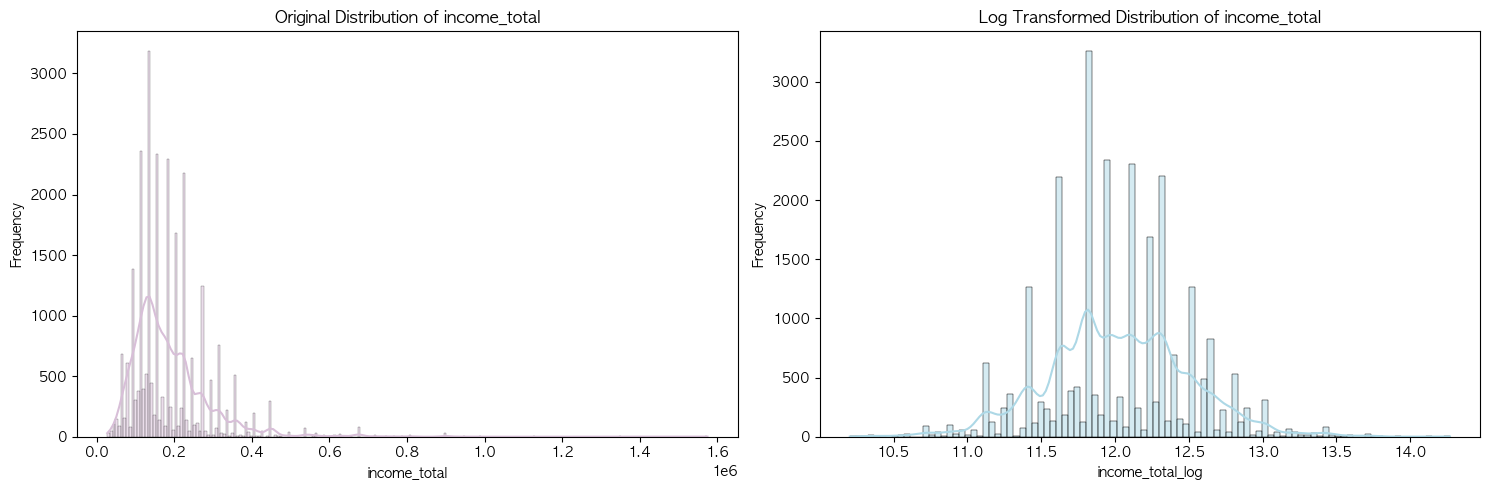

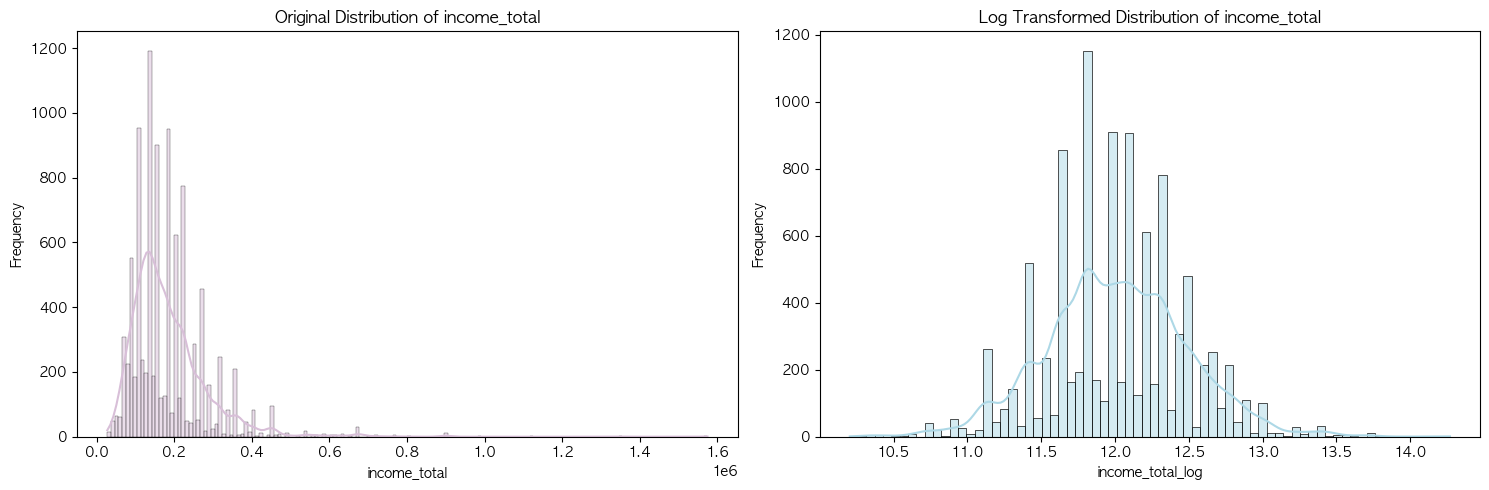

In [36]:
def log_transform_column(df, column):
    
    # 로그 변환을 새로운 열로 추가
    new_column_name = f'{column}_log'
    df[new_column_name] = np.log1p(1+df[column])
    
    # 시각화를 위한 그래프 설정
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # 원래 변수에 대한 히스토그램 그리기
    sns.histplot(df[column], kde=True, color='thistle', ax=axes[0])
    axes[0].set_title(f'Original Distribution of {column}')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Frequency')

    # 로그 변환 변수에 대한 히스토그램 그리기
    sns.histplot(df[new_column_name], kde=True, color='lightblue', ax=axes[1])
    axes[1].set_title(f'Log Transformed Distribution of {column}')
    axes[1].set_xlabel(new_column_name)
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()
    
    return df

# 각각 적용
train_df = log_transform_column(train_df, 'income_total')
test_df = log_transform_column(test_df, 'income_total')

# 기존 칼럼 삭제
train_df = train_df.drop(['income_total_log'], axis=1)
test_df = test_df.drop(['income_total_log'], axis=1)

## 표준화(StandardScale)

In [37]:
numerical_feats = ['work_phone', 'phone', 'email', 'family_size', 'begin_month', 'before_EMPLOYED_month', 'before_EMPLOYED_week', 'Age', 
                   'DAYS_BIRTH_month', 'DAYS_BIRTH_week', 'EMPLOYED', 'DAYS_EMPLOYED_month', 'DAYS_EMPLOYED_week', 'income_mean']

# 'income_total'를 수치형 변수 목록에서 제거 [이미 로그변환 했으니 제외]
# 변수 선택에서 삭제된 3개 : 'child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED'
# 로그변환한 'income_total'은 제외
# 구간화 변수 넣게 되면 : 'DAYS_BIRTH_bin', 'begin_month_bin', 'DAYS_EMPLOYED_bin' 추가하면 됨
# 변수선택(vif)일 경우 삭제되는 변수 : 'DAYS_BIRTH', 'before_EMPLOYED', 'DAYS_EMPLOYED', 'child_num', 'ability', 'income_total_befofeEMP_ratio'
                                # 즉, 추가로 'before_EMPLOYED', 'ability', 'income_total_befofeEMP_ratio' 삭제하면 됨.

# [원본] : 혹시 모르니 따로 만들어두기
# numerical_feats = ['work_phone', 'phone', 'email', 'family_size', 'begin_month', 'before_EMPLOYED', 'income_total_befofeEMP_ratio', 'before_EMPLOYED_month', 'before_EMPLOYED_week', 'Age', 
#                    'DAYS_BIRTH_month', 'DAYS_BIRTH_week', 'EMPLOYED', 'DAYS_EMPLOYED_month', 'DAYS_EMPLOYED_week', 'ability', 'income_mean']


# StandardScaler 객체를 생성 및 초기화!
scaler = StandardScaler()

# 학습 데이터의 수치형 변수에 대해 scaler를 학습 데이터에 맞게 fitting하고 변수를 변환
train_df[numerical_feats] = scaler.fit_transform(train_df[numerical_feats])

# 테스트 데이터의 변수를 변환할 때에는 fitting한 scaler를 이용하여 표준화
test_df[numerical_feats] = scaler.transform(test_df[numerical_feats])

In [38]:
train_df.head()

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,email,occyp_type,family_size,begin_month,credit,before_EMPLOYED_month,before_EMPLOYED_week,Age,DAYS_BIRTH_month,DAYS_BIRTH_week,EMPLOYED,DAYS_EMPLOYED_month,DAYS_EMPLOYED_week,income_mean,ID
0,1,1,1,202500.0,1,1,1,1,-0.538321,-0.645632,-0.316977,1,-0.216262,-1.215242,1.0,0.166791,-1.348417,-0.452826,0.442795,-0.443485,0.994253,-1.230046,-1.077087,0.002062,1
1,1,1,2,247500.0,1,2,2,2,-0.538321,-0.645632,3.154805,2,0.897294,-1.275633,1.0,-0.418442,-0.458877,-1.060773,0.442795,-0.443485,-0.250471,-0.424295,-1.077087,-0.254157,2
2,2,2,2,450000.0,2,1,1,2,-0.538321,1.548870,-0.316977,3,-0.216262,-0.248981,2.0,0.752023,-0.458877,0.763069,-1.582567,0.451504,0.994253,-0.424295,-0.223607,1.693108,3
3,1,1,2,202500.0,1,2,1,2,-0.538321,1.548870,-0.316977,4,-0.216262,0.656889,0.0,-1.296291,-1.348417,-0.192277,1.310808,1.346494,-0.094880,1.187206,0.629874,0.002062,4
4,1,2,2,157500.0,3,1,1,2,-0.538321,-0.645632,-0.316977,3,-0.216262,-0.007416,2.0,1.629872,1.320202,-0.192277,1.021471,-1.338475,-0.094880,1.455790,-1.077087,-0.305401,5


In [39]:
test_df.head()

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,email,occyp_type,family_size,begin_month,before_EMPLOYED_month,before_EMPLOYED_week,Age,DAYS_BIRTH_month,DAYS_BIRTH_week,EMPLOYED,DAYS_EMPLOYED_month,DAYS_EMPLOYED_week,income_mean,ID
0,2,2,1,112500.0,4,2,2,2,-0.538321,1.548870,-0.316977,1,-0.216262,2.045889,-1.296291,-0.458877,1.457866,-1.293230,-0.443485,-0.872832,-1.230046,-1.077087,-0.612864,1402
1,1,1,2,135000.0,3,1,1,2,-0.538321,1.548870,-0.316977,6,-0.216262,0.596497,0.459407,0.430662,0.676220,0.732133,-0.443485,2.705748,-0.961462,0.629874,-0.459133,312
2,1,1,2,69372.0,2,2,1,2,1.857628,1.548870,-0.316977,2,-0.216262,0.838063,0.166791,0.430662,-0.018578,-1.293230,-0.443485,-0.872832,0.650039,1.483355,-0.907537,2737
3,2,2,1,112500.0,1,2,1,2,1.857628,-0.645632,-0.316977,7,-0.216262,0.898454,-0.125826,1.320202,0.763069,0.153458,-1.338475,0.060710,-1.230046,-0.223607,-0.612864,8084
4,1,2,2,225000.0,3,1,1,2,1.857628,-0.645632,-0.316977,3,-0.216262,-1.094459,-0.125826,-0.458877,0.415671,0.153458,0.451504,3.016929,-1.230046,-1.077087,0.155793,5263


In [40]:
# train 데이터 행 몇개 삭제해서 오류남.. index 초기화 해줘야 함.
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

## 군집화 변수 생성

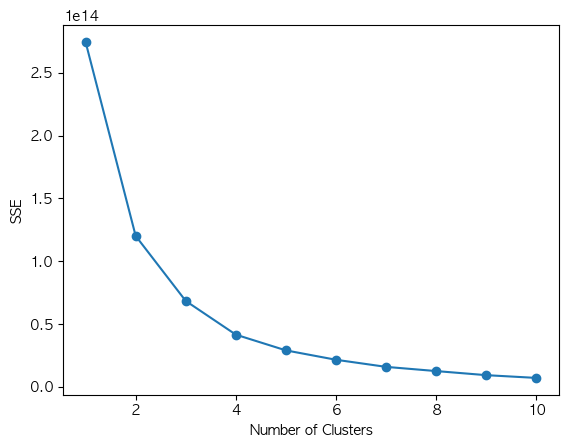

In [41]:
# elbow point로 K를 구해봄 [범위를 (1,40)으로 두고 해도 결과는 똑같이 K=4일 때 급격하게 감소가 끝나는 구간이었음]
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

kmeans_train = train_df.drop(['credit'], axis=1)

# SSE 계산을 위한 리스트
sse = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(kmeans_train)
    sse.append(kmeans.inertia_)

# 엘보우 메서드 그래프
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

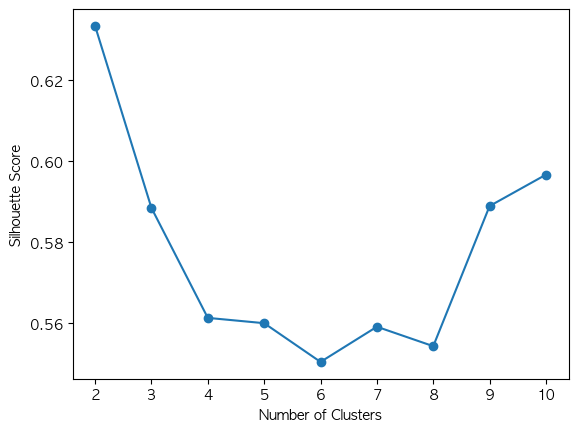

In [42]:
from sklearn.metrics import silhouette_score

sil_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(kmeans_train)
    sil_score = silhouette_score(kmeans_train, kmeans.labels_)
    sil_scores.append(sil_score)

# 실루엣 분석 그래프
plt.plot(range(2, 11), sil_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [41]:
# 클러스터링 구성 변수 생성!!
from sklearn.cluster import KMeans

kmeans_train = train_df.drop(['credit'], axis=1)
kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
train_df['cluster'] = kmeans.predict(kmeans_train)
test_df['cluster'] = kmeans.predict(test_df)

## 데이터 불균형 해결 

In [43]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN

In [53]:
# Credit 분포 시각화
fig = px.pie(train, names='credit', title='Original Credit Distribution')
fig.show()

# 데이터 저장
original_counts = train['credit'].value_counts()

In [46]:
# 방법 1: Under Random Sampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(train.drop('credit', axis=1), train['credit'])

# Credit 분포 시각화
fig = px.pie(pd.DataFrame(y_resampled, columns=['credit']), names='credit', title='Under Random Sampling')
fig.show()

# 데이터 저장
under_random_counts = pd.Series(y_resampled).value_counts()

In [47]:
# 방법 2: Tomek Links
tl = TomekLinks()
X_resampled, y_resampled = tl.fit_resample(train.drop('credit', axis=1), train['credit'])

# Credit 분포 시각화
fig = px.pie(pd.DataFrame(y_resampled, columns=['credit']), names='credit', title='Tomek Links')
fig.show()

# 데이터 저장
tomek_links_counts = pd.Series(y_resampled).value_counts()

In [48]:
# 데스크탑으로 돌려봐야 하나? 왤케 맥북 시간 오래 걸리는 것을 떠나서 왤케 소리를 내지..?

# 방법 3: CNN Rule
cnn = CondensedNearestNeighbour()
X_resampled, y_resampled = cnn.fit_resample(train.drop('credit', axis=1), train['credit'])

# Credit 분포 시각화
fig = px.pie(pd.DataFrame(y_resampled, columns=['credit']), names='credit', title='CNN Rule')
fig.show()

# 데이터 저장
cnn_counts = pd.Series(y_resampled).value_counts()

KeyboardInterrupt: 

In [49]:
# 방법 4: Over Random Sampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(train.drop('credit', axis=1), train['credit'])

# Credit 분포 시각화
fig = px.pie(pd.DataFrame(y_resampled, columns=['credit']), names='credit', title='Over Random Sampling')
fig.show()

# 데이터 저장
over_random_counts = pd.Series(y_resampled).value_counts()

In [50]:
# 방법 5: SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(train.drop('credit', axis=1), train['credit'])

# Credit 분포 시각화
fig = px.pie(pd.DataFrame(y_resampled, columns=['credit']), names='credit', title='SMOTE')
fig.show()

# 데이터 저장
smote_counts = pd.Series(y_resampled).value_counts()

In [51]:
# 방법 6: Borderline-SMOTE
bsmote = BorderlineSMOTE(random_state=42)
X_resampled, y_resampled = bsmote.fit_resample(train.drop('credit', axis=1), train['credit'])

# Credit 분포 시각화
fig = px.pie(pd.DataFrame(y_resampled, columns=['credit']), names='credit', title='Borderline-SMOTE')
fig.show()

# 데이터 저장
bsmote_counts = pd.Series(y_resampled).value_counts()

In [52]:
# 방법 7: ADASYN
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(train.drop('credit', axis=1), train['credit'])

# Credit 분포 시각화
fig = px.pie(pd.DataFrame(y_resampled, columns=['credit']), names='credit', title='ADASYN')
fig.show()

# 데이터 저장
adasyn_counts = pd.Series(y_resampled).value_counts()

In [55]:
import plotly.graph_objects as go

# 모든 결과를 하나의 데이터프레임으로 합치기
result_df = pd.DataFrame({
    'Original': original_counts,
    'Under Random Sampling': under_random_counts,
    'Tomek Links': tomek_links_counts, # 얜 왜 개수 안맞냐? -> 불균형이 심한 경우 거리에 따라 이럴 수 있음.
    'CNN Rule': under_random_counts, # KNN과 비슷한 방식이라 너무 오래 걸림. 안할 것이기에 패스
    'Over Random Sampling': over_random_counts,
    'SMOTE': smote_counts,
    'Borderline-SMOTE': bsmote_counts,
    'ADASYN': adasyn_counts
})

# 막대 그래프 생성
fig = go.Figure()

for credit_value in result_df.index:
    fig.add_trace(go.Bar(x=result_df.columns, y=result_df.loc[credit_value], name=f'Credit {credit_value}'))

fig.update_layout(barmode='group', title='Credit Distribution Comparison', xaxis_title='Sampling/Transformation Method', yaxis_title='Count')
fig.show()

In [ ]:
train_df.info()

In [ ]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Random Over Sampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(train_df.drop('credit', axis=1), train_df['credit'])

# 새로운 데이터프레임 생성
train_df_resampled = pd.DataFrame(X_resampled, columns=train_df.columns[:-1])  # 목적 변수를 제외한 나머지 특성
train_df_resampled['credit'] = y_resampled  # 목적 변수 추가

# train_df_resampled를 사용하여 이후 모델 학습 등을 진행

In [ ]:
# 🔥 데이터 불균형 처리 자체가 성능을 높여주는 경우가 있긴 한데, 우린 아님. 결과가 좋지 않게 나옴! [미실시 예정]
# 🔥 언더 샘플링은 정보의 손실을 불러오면서, 오버 샘플링의 경우 언더 샘플링도 그렇지만, 과/과소 적합이 발생될 때 있음
train_df_resampled.info()

## PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding as LLE
from umap import UMAP

In [ ]:
# PCA 적용해보기
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 숫자형 특성 선택
numeric_features = train_df.select_dtypes(include=[np.number])

# 데이터 표준화 (Standardization)
scaler = StandardScaler()
numeric_features_standardized = scaler.fit_transform(numeric_features)

# PCA 모델 생성 및 학습
n_components = 2
pca = PCA(n_components=n_components)
train_df_pca = pca.fit_transform(numeric_features_standardized)

# PCA 변환된 데이터프레임 출력
print("Original shape:", train_df.shape)
print("Transformed shape:", train_df_pca.shape)

In [ ]:
# 각 차원 축소 기법을 정의

# PCA: 주성분 분석
pca = PCA(n_components=10)  # 축소할 차원의 수를 설정함. 데이터의 분산을 얼마나 보존할지 결정

# LDA: 선형 판별 분석
lda = LDA(n_components=2)    # 목표 차원의 수를 설정함. 클래스 간의 차이를 최대화하는 특성 벡터를 찾아 차원을 축소

# t-SNE: t-distributed Stochastic Neighbor Embedding
tsne = TSNE(n_components=2)  # 축소할 차원의 수를 설정함. 고차원 데이터의 군집 간 구분을 강화하여 시각화에 사용

# LLE: Locally Linear Embedding
lle = LLE(n_neighbors=10, n_components=2)  # 이웃의 수와 목표 차원의 수를 설정함. 국부적인 연결을 보존하는 방식으로 차원을 축소

# UMAP: Uniform Manifold Approximation and Projection
umap = UMAP(n_components=2)  # 축소할 차원의 수를 설정함. t-SNE와 유사한 비선형 차원 축소 방법으로 효율적인 결과를 제공

# 타겟 변수 : credit
train_labels = train['credit']

# 차원 축소 적용
pca_result = pca.fit_transform(train)
lda_result = lda.fit_transform(train, train_labels)  # LDA는 클래스 정보가 필요
tsne_result = tsne.fit_transform(train)
lle_result = lle.fit_transform(train)
umap_result = umap.fit_transform(train)

# 결과 확인
print(f"PCA 결과 차원: {pca_result.shape}")
print(f"LDA 결과 차원: {lda_result.shape}")
print(f"t-SNE 결과 차원: {tsne_result.shape}")
print(f"LLE 결과 차원: {lle_result.shape}")
print(f"UMAP 결과 차원: {umap_result.shape}")

# <span style="color:gray">⭐️Modeling⭐️</span> 

In [42]:
# 우선 데이터 최종 결과 복사 해놓기
train = train_df.copy()
test = test_df.copy()

## <span style="color:orange">[복습 X] 다양하게 적용해보기</span> 

#### [1] kfold 적용하지 않고 단순히 분류 모델 6개 적용해보기

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

# train 데이터셋에서 목적변수와 설명변수 분리
X_train = train.drop('credit', axis=1)
y_train = train['credit']

# test 데이터셋에서 설명변수 분리
X_test = test.copy()

# [예시] 단순히 각 모델 학습
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, y_train)

catboost_model = CatBoostClassifier(random_state=42, verbose=0)
catboost_model.fit(X_train, y_train)

logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

# 각 모델 예측
rf_pred = rf_model.predict(X_test)
gb_pred = gb_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
lgbm_pred = lgbm_model.predict(X_test)
catboost_pred = catboost_model.predict(X_test)
logistic_pred = logistic_model.predict(X_test)

# 예측 결과 확인
print("Random Forest 예측 결과:", rf_pred)
print("Gradient Boosting 예측 결과:", gb_pred)
print("XGBoost 예측 결과:", xgb_pred)
print("LightGBM 예측 결과:", lgbm_pred)
print("CatBoost 예측 결과:", catboost_pred)
print("Logistic Regression 예측 결과:", logistic_pred)

#### [2] catboost S_K-Fold 사용

In [ ]:
# cat boost 사용

from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import log_loss

# 데이터 기본 속성 설정 (우선, 코드공유에 나와있는 임의의 값 적용해봄)
n_est = 2000
seed = 42
n_fold = 15
n_class = 3

# 타겟 변수 설정
target = 'credit'

# 훈련 데이터와 테스트 데이터 프레임 설정
X = train_df.drop(target, axis=1)
y = train_df[target]
X_test = test_df

# Stratified K-Fold 교차 검증 설정
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
    folds.append((train_idx, valid_idx))

# CatBoost 모델 예측 결과를 저장할 배열 초기화
cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))

# CatBoost에 적용할 카테고리 변수 목록
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']

# 교차 검증 수행
for fold in range(n_fold):
    print(f'\n----------------- Fold {fold} -----------------\n')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    
    # CatBoost에서 사용할 데이터 형식으로 변환
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

    # CatBoost 모델 초기화 및 학습
    model_cat = CatBoostClassifier()
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
    # 검증 데이터에 대한 예측 결과 저장
    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    
    # 테스트 데이터에 대한 예측 결과 누적
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold
    
    # 교차 검증 시의 로그 손실 출력
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')

# 전체 데이터에 대한 로그 손실 출력
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')

In [ ]:
# 피처중요도 시각화 함수

def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

In [ ]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

In [ ]:
cat_pred_test

In [ ]:
# 결과 대입
sample_submission_df.iloc[:, 1:] = cat_pred_test

In [ ]:
sample_submission_df

In [ ]:
# 결과 저장
sample_submission_df.to_csv('/Users/raekkkky/Desktop/DNA/winter 24/project7/submission_Final.csv', index=False)

#### [3] 다중로지스틱회귀 train_test_split 사용

In [ ]:
# 필요한 라이브러리 import
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss  # 추가된 부분
import pandas as pd

# 학습 데이터와 테스트 데이터 분리
X_train = train_df.drop(['credit'], axis=1)  # 목적 변수인 'credit' 제외한 변수들을 학습 데이터로 사용
y_train = train_df['credit']  # 목적 변수인 'credit'
X_test = test_df.copy()  # 테스트 데이터

# 표준화 (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 다중 로지스틱 회귀 모델 생성 및 학습
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# 테스트 데이터에 대한 예측
logis_pred_test = model.predict_proba(X_test_scaled)

# 결과 확인
print(logis_pred_test)

# 전체 데이터에 대한 로그 손실 계산 및 출력
logis_pred = model.predict_proba(X_train_scaled)
log_loss_value = log_loss(y_train, logis_pred)
print(f'\tLog Loss: {log_loss_value:.6f}')

In [ ]:
# 피처중요도 시각화 함수

def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

In [ ]:
plot_feature_importance(model.coef_[0],X_test.columns,'Multiple Logistic Regression')

In [ ]:
# 결과 대입
sample_submission_df.iloc[:, 1:] = logis_pred_test

In [ ]:
sample_submission_df

In [ ]:
# 결과 저장
sample_submission_df.to_csv('/Users/raekkkky/Desktop/DNA/winter 24/project7/submission_Final.csv', index=False)

#### [4] 다중로지스틱회귀 S_K-Fold 사용

In [ ]:
# 필요한 라이브러리 import
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
import numpy as np

# 학습 데이터와 테스트 데이터 분리
X_train = train_df.drop(['credit'], axis=1)  # 목적 변수인 'credit' 제외한 변수들을 학습 데이터로 사용
y_train = train_df['credit']  # 목적 변수인 'credit'
X_test = test_df.copy()  # 테스트 데이터

# 다중 로지스틱 회귀 모델 교차 검증
def cross_validate_logistic_regression(X, y, X_test, n_fold=15):
    skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
    
    # 다중 로지스틱 회귀 모델 초기화
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)

    # 표준화 (Standardization)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_test_scaled = scaler.transform(X_test)
    
    # 예측 결과 저장 배열 초기화
    logis_pred = np.zeros((X.shape[0], 3))
    logis_pred_test_final = np.zeros((X_test.shape[0], 3))  # 추가된 부분
    
    for fold, (train_idx, valid_idx) in enumerate(skfold.split(X, y)):
        print(f'\n----------------- Fold {fold} -----------------\n')
        X_train, X_valid, y_train, y_valid = X_scaled[train_idx], X_scaled[valid_idx], y.iloc[train_idx], y.iloc[valid_idx]

        # 모델 학습
        model.fit(X_train, y_train)
        
        # 검증 데이터에 대한 예측 결과 저장
        logis_pred[valid_idx] = model.predict_proba(X_valid)
        logis_pred_test_final += model.predict_proba(X_test_scaled) / n_fold  # 추가된 부분
        
        # 교차 검증 시의 로그 손실 출력
        print(f'CV Log Loss Score: {log_loss(y_valid, logis_pred[valid_idx]):.6f}')

    # 전체 데이터에 대한 로그 손실 출력
    log_loss_value = log_loss(y, logis_pred)
    print(f'\tLog Loss: {log_loss_value:.6f}')
    
    return logis_pred, logis_pred_test_final  # 반환값 수정

# 교차 검증 수행
logis_pred, logis_pred_test_final = cross_validate_logistic_regression(X_train, y_train, X_test)

# 테스트 데이터에 대한 예측 결과 출력
print(logis_pred_test_final)


In [ ]:
logis_pred_test_final

In [ ]:
# 결과 대입
sample_submission_df.iloc[:, 1:] = logis_pred_test_final

In [ ]:
sample_submission_df

In [ ]:
# 결과 저장
sample_submission_df.to_csv('/Users/raekkkky/Desktop/DNA/winter 24/project7/submission_Final.csv', index=False)

#### [5] 모두 적용해봄 [12개 분류기법 적용만함.]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# 데이터 불러오기 함수 (load_data)를 가정하고, 훈련 및 테스트 데이터를 불러옵니다.
# train_df, test_df = load_data()

# 훈련 데이터 분리
X = train_df.drop('credit', axis=1)
y = train_df['credit']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 분류 알고리즘 목록
classifiers = [
    ('랜덤 포레스트', RandomForestClassifier()),
    ('에이다부스트', AdaBoostClassifier()),
    ('그래디언트 부스팅', GradientBoostingClassifier()),
    ('로지스틱 회귀', LogisticRegression()),
    ('SGD 분류기', SGDClassifier(loss='log')),
    ('K 최근접 이웃', KNeighborsClassifier()),
    ('나이브 베이즈', GaussianNB()),
    ('신경망', MLPClassifier()),
    ('SVM', SVC(probability=True)),
    ('XGBoost', XGBClassifier()),
    ('LightGBM', LGBMClassifier()),
    ('CatBoost', CatBoostClassifier())
]

# 각 분류기를 훈련하고 평가합니다.
results = []
for clf_name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_val)
    logloss = log_loss(y_val, y_pred_proba)
    results.append((clf_name, logloss))
    print(f'{clf_name} - Log Loss: {logloss}')

# 결과를 정렬하고 최적의 모델을 선택합니다.
results.sort(key=lambda x: x[1])
best_model_name, best_logloss = results[0]
print(f'\n최적의 모델: {best_model_name} (Log Loss: {best_logloss})')

# 최적의 모델을 사용하여 테스트 데이터를 예측합니다.
best_model = [clf for clf_name, clf in classifiers if clf_name == best_model_name][0]
test_pred_proba = best_model.predict_proba(test_df)

In [ ]:
# 결과 대입
sample_submission_df.iloc[:, 1:] = test_pred_proba

In [ ]:
sample_submission_df

In [ ]:
# 결과 저장
sample_submission_df.to_csv('/Users/raekkkky/Desktop/DNA/winter 24/project7/submission_Final.csv', index=False)

#### [6] 군집화 변수 추가 + 칼럼삭제 + catboost + s_f_fold

In [ ]:
# 파생변수와 다중공선을 보이는 컬럼 삭제
cols = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import log_loss

n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')

In [ ]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

In [ ]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

In [ ]:
sample_submission_df.iloc[:, 1:] = cat_pred_test
sample_submission_df

In [ ]:
sample_submission_df.to_csv('/Users/raekkkky/Desktop/DNA/winter 24/project7/submission_Final.csv', index=False)

#### [7] pca 적용.. 실패

In [ ]:
# 차원축소까지 해본거 [문제는 test 데이터도 차원축소 해야함]
# 전체적으로 catboost 코드 다 수정해야 함.. 시간 오래 걸릘 듯.. 나중에 하자!

In [ ]:
train_df_pca

In [ ]:
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import log_loss

n_est = 2000
seed = 42
n_fold = 15
n_class = 3

X = train_df_pca # 차원축소는 독립변수만으로 진행된다는점 참고!
y = train['credit']
X_test = test

skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')

#### [8] 데이터 불균형 적용 + 캣부스트

In [ ]:
# SMOTE, 오버랜덤샘플링 둘 다 적용해본 결과 [train_df_resampled]
# 아쉽게도 둘 다 ID는 포함이 안됨 (이유 :  오직 입력 특성과 대상 변수(목적 변수)에만 적용되기에 식별자는 자동 제거임)

In [ ]:
# train 데이터 행 몇개 삭제해서 오류남.. index 초기화 해줘야 함.
train_df_resampled.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# 우선 데이터 최종 결과 복사 해놓기
train = train_df_resampled.copy()
test = test_df.copy()

In [ ]:
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import log_loss

n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')

In [ ]:
sample_submission_df.iloc[:, 1:] = cat_pred_test
sample_submission_df

In [ ]:
sample_submission_df.to_csv('/Users/raekkkky/Desktop/DNA/winter 24/project7/submission_Final.csv', index=False)

#### [9] 변수 선택(3개만..?) + SMOTE(X) + catboost

In [ ]:
# 변수선택 까지! SMOTE 안하고 변수선택한 것에 catboost 적용
# 근데 변수선택 따로 VIF 하지 말고 코드공유에 나온 것처럼 3개만 삭제

In [ ]:
# train 데이터 행 몇개 삭제해서 오류남.. index 초기화 해줘야 함.
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [ ]:
# 우선 데이터 최종 결과 복사 해놓기
train = train_df.copy()
test = test_df.copy()

In [ ]:
cols = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import log_loss

n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')

In [ ]:
sample_submission_df.iloc[:, 1:] = cat_pred_test
sample_submission_df

In [ ]:
sample_submission_df.to_csv('/Users/raekkkky/Desktop/DNA/winter 24/project7/submission_Final.csv', index=False)

## <span style="color:orange">[총 복습 후 재 도전]</span> 

#### Catboost 적용

In [43]:
# [1] 결측NaN, 이상치O, 구간화X, 파생13, Ordinal, 변수선택[코드]3, log1p, 표준화, 군집화변수, 불균형X, 차원X, (Catboost + S_K-fold)
# [2] 결측NaN, 이상치O, 구간화O, 파생13, Ordinal, 변수선택[코드]3, log1p, 표준화, 군집화변수, 불균형X, 차원X, (Catboost + S_K-fold)
# [3] 결측NaN, 이상치O, 구간화X, 파생13, Ordinal, 변수선택[VIF]6, log1p, 표준화, 군집화변수, 불균형X, 차원X, (Catboost + S_K-fold)
# [4] 결측NaN, 이상치O(이상치 1행삭제 미실시), 구간화X, 파생13, Ordinal, 변수선택[VIF]6, log1p, 표준화, 군집화변수, 불균형X, 차원X, (Catboost + S_K-fold) 🔥
# [5] 결측NaN, 이상치O(이상치 1행삭제 미실시), 구간화O, 파생13, Ordinal, 변수선택[VIF]6, log1p, 표준화, 군집화변수, 불균형X, 차원X, (Catboost + S_K-fold[K=20])
# [6] 결측NaN, 이상치O(이상치 1행삭제 미실시), 구간화X, 파생13, Ordinal, 변수선택[VIF]6, log1p, 표준화, 군집화변수[n=4], 불균형X, 차원X, (Catboost + S_K-fold)

In [44]:
n_est = 2000 # 트리의 개수
seed = 42
n_fold = 15
n_class = 3 # 분류를 3개로 나누기 때문에 초기화를 위한 비어있는 3개 분륰 클래스 생성

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [45]:
# Stratified K-Fold 설정
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx)) # folds 리스트에는 각 Fold에 대한 훈련(train) 및 검증(valid) 인덱스가 저장

# CatBoost 모델 및 예측 초기화
cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))

# [범주형 데이터들 총 6개]
# 처음 범주형은 9개였는데 왜 6개만 할까?
# -> gender, car, reality는 애초에 카테고리에 없던 phone 처럼 0또는 1의 유무 데이터임. 즉 이진 데이터임
# [결론] : 캣 부스트에서는 "범주가 여러개인 것들을 범주형으로 선정" 해놓고 진행하는거 같음.
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']

# 각 Fold에 대해 CatBoost 모델을 초기화하고 훈련
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
    
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]

  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)

    # 15로 나눠서 평균 만들어 결과로 만들어 버리기~!
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold

  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')

# 모든 Fold에서의 검증 결과를 종합하여 최종 교차 검증 결과를 출력
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')


----------------- Fold 0 -----------------

Learning rate set to 0.115127
0:	learn: 1.0348531	test: 1.0333702	best: 1.0333702 (0)	total: 90.8ms	remaining: 1m 30s
100:	learn: 0.7053679	test: 0.6411563	best: 0.6411563 (100)	total: 2.07s	remaining: 18.4s
200:	learn: 0.6886603	test: 0.6400423	best: 0.6394533 (181)	total: 4.16s	remaining: 16.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.639453254
bestIteration = 181

Shrink model to first 182 iterations.
CV Log Loss Score: 0.639453

----------------- Fold 1 -----------------

Learning rate set to 0.115127
0:	learn: 1.0347006	test: 1.0340077	best: 1.0340077 (0)	total: 14.8ms	remaining: 14.8s
100:	learn: 0.7067371	test: 0.6727429	best: 0.6727382 (98)	total: 1.8s	remaining: 16.1s
200:	learn: 0.6880882	test: 0.6733037	best: 0.6722633 (126)	total: 3.89s	remaining: 15.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6722632563
bestIteration = 126

Shrink model to first 127 iterations.
CV Log Loss 

In [46]:
# 피쳐중요도 시각화 함수 제작!

def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

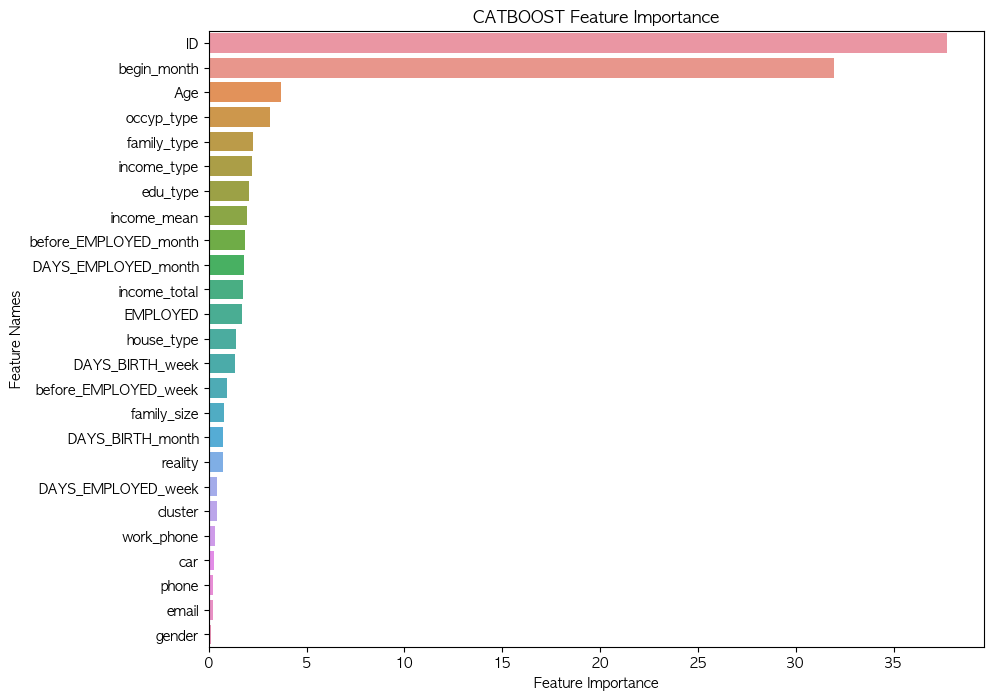

In [47]:
# 피쳐중요도 시각화
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')
# model_cat.get_feature_importance() 속성이 피쳐중요도를 보여줌
# X_test.columns 칼럼 이름들을 보여줌

In [48]:
# 모든 행(:)을 포함하되, 두 번째 열부터 마지막 열까지의 모든 열(1:)을 선택
sample_submission_df.iloc[:, 1:] = cat_pred_test
sample_submission_df

,index,0,1,2
0,26457,0.114418,0.166037,0.719545
1,26458,0.342588,0.201669,0.455743
2,26459,0.039816,0.080545,0.879639
3,26460,0.055150,0.079136,0.865714
4,26461,0.085233,0.225309,0.689458
...,...,...,...,...
9995,36452,0.071628,0.226853,0.701518
9996,36453,0.310305,0.185141,0.504554
9997,36454,0.051066,0.118369,0.830565
9998,36455,0.150250,0.313198,0.536553


In [49]:
sample_submission_df.to_csv('/Users/raekkkky/Desktop/DNA/winter 24/project7/submission_Final.csv', index=False)

#### 다중회귀분석

In [ ]:
# 위에서 따로 진행했었는데, 좋은 결과가 딱히 없었음.

#### LGBM

In [ ]:
# 위에서 따로 진행했었는데, 좋은 결과가 딱히 없었음.

#### XGB

In [ ]:
# 위에서 따로 진행했었는데, 좋은 결과가 딱히 없었음.

#### Random Forest

In [ ]:
# 위에서 따로 진행했었는데, 좋은 결과가 딱히 없었음.

## <span style="color:orange">[연우가 모델링 한 것들]</span> 

In [1]:
# 나중에 전체적인 코드 설명 연우한테 부탁해서 들어보자. [너무 복잡하고 뒤죽박죽이라 코드 해석이 너무 어려움]

### 모델링

In [ ]:
from typing import Dict, Tuple, Union, List

In [ ]:
def stratified_kfold_cat(
    params: Dict[str, Union[int, float, str, List[str]]],
    n_fold,
    X,
    target,
    X_test,
) -> Tuple[np.ndarray, np.ndarray]:
    folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
    splits = folds.split(X, target)
    cat_oof = np.zeros((X.shape[0], 3))
    cat_preds = np.zeros((X_test.shape[0], 3))
    cat_cols = [c for c in X.columns if X[c].dtypes == "int64"]

    for fold, (train_idx, valid_idx) in enumerate(splits):
        print(f"============ Fold {fold} ============\n")
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]
        train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
        valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

        model = CatBoostClassifier(**params)

        model.fit(
            train_data,
            eval_set=valid_data,
            early_stopping_rounds=100,
            use_best_model=True,
            verbose=100,
        )

        cat_oof[valid_idx] = model.predict_proba(X_valid)
        cat_preds += model.predict_proba(X_test) / n_fold

    log_score = log_loss(target, cat_oof)
    print(f"Log Loss Score: {log_score:.5f}\n")
    return cat_oof, cat_preds

In [ ]:
# Light GBM
def stratified_kfold_lgbm(
    params: Dict[str, Union[int, float, str]],
    n_fold: int,
    X: pd.DataFrame,
    y: pd.DataFrame,
    X_test: pd.DataFrame,
) -> Tuple[np.ndarray, np.ndarray]:
    folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
    splits = folds.split(X, y)
    lgb_oof = np.zeros((X.shape[0], 3))
    lgb_preds = np.zeros((X_test.shape[0], 3))

    for fold, (train_idx, valid_idx) in enumerate(splits):
        print(f"============ Fold {fold} ============\n")
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        pre_model = LGBMClassifier(**params)

        pre_model.fit(
            X_train,
            y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            eval_metric='multi_logloss',
        )
        params2 = params.copy()
        params2["learning_rate"] = params["learning_rate"] * 0.1

        model = LGBMClassifier(**params2)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            eval_metric='multi_logloss',
            init_model=pre_model,
        )
        lgb_oof[valid_idx] = model.predict_proba(X_valid)
        lgb_preds += model.predict_proba(X_test) / n_fold

    log_score = log_loss(y, lgb_oof)
    print(f"Log Loss Score: {log_score:.5f}")

    return lgb_oof, lgb_preds

In [ ]:
# XGB
def stratified_kfold_xgb(
    params: Dict[str, Union[int, float, str]],
    n_fold,
    X,
    y,
    X_test,
) -> Tuple[np.ndarray, np.ndarray]:

    folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
    splits = folds.split(X, y)
    xgb_oof = np.zeros((X.shape[0], 3))
    xgb_preds = np.zeros((X_test.shape[0], 3))

    for fold, (train_idx, valid_idx) in enumerate(splits):
        print(f"============ Fold {fold} ============\n")
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = XGBClassifier(**params)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            early_stopping_rounds=100,
            verbose=100,
        )

        xgb_oof[valid_idx] = model.predict_proba(X_valid)
        xgb_preds += model.predict_proba(X_test) / n_fold

    log_score = log_loss(y, xgb_oof)
    print(f"Log Loss Score: {log_score:.5f}")

    return xgb_oof, xgb_preds

In [ ]:
# 하이퍼 파라미터 조정

cat_params = {
    "random_state": 42,
    "eval_metric": "MultiClass",
    "loss_function": "MultiClass",
    'learning_rate': 0.01443340240633889,
    'n_estimators': 6728, 'max_depth': 8,
    'random_strength': 51,
    "cat_features": ['income_type', 'edu_type', 'family_type', 'house_type','occyp_type','DAYS_BIRTH_bin', 'begin_month_bin', 'DAYS_EMPLOYED_bin',
       'g_r_c', 'e_p_w','befor_EMPLOYED_year','ID','occyp_is']}
cat_oof, cat_preds = stratified_kfold_cat(cat_params, 10, X, target, X_test)

xgb_params = {
    "random_state": 42,
    "n_estimators": 10000,
    "objective": "multi:softmax",
    "eval_metric": "mlogloss",
    'learning_rate': 0.1,
    'max_depth': 4,
    'num_leaves': 4,
    'colsample_bytree': 0.65,
    'max_bin': 360}
xgb_oof, xgb_preds = stratified_kfold_xgb(xgb_params, 10, X, target, X_test)

lgb_params = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "verbosity":0,
    "random_state": 42,
    "boosting_type": "gbdt",
    "learning_rate": 0.05, 'max_depth': 5, 'num_leaves': 147,}
lgbm_oof, lgbm_preds = stratified_kfold_lgbm(lgb_params, 10, X, target, X_test)

train_pred = np.concatenate([cat_oof, lgbm_oof, xgb_oof], axis=1)
train_pred.shape

test_pred = np.concatenate([cat_preds, lgbm_preds, xgb_preds], axis=1)
test_pred.shape

In [ ]:
import torch
!pip install pytorch_tabnet
device = "cuda" if torch.cuda.is_available() else "cpu"
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier

In [ ]:
n_fold = 10
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
splits = folds.split(train_pred, target)
net_oof = np.zeros((train_pred.shape[0], 3))
net_preds = np.zeros((test_pred.shape[0], 3))
for fold, (train_idx, valid_idx) in enumerate(splits):
    print(f"============ Fold {fold} ============\n")
    X_train, X_valid = train_pred[train_idx], train_pred[valid_idx]
    y_train, y_valid = target[train_idx], target[valid_idx]
    model = TabNetMultiTaskClassifier(
            n_d=64, n_a=64, n_steps=1,
            lambda_sparse=1e-4,
            optimizer_fn=torch.optim.Adam,
            optimizer_params=dict(lr=2e-2),
            scheduler_params = {"gamma": 0.9, "step_size": 50},
            scheduler_fn=torch.optim.lr_scheduler.StepLR,
            mask_type="entmax",
    )

    model.fit(
        X_train, y_train.reshape(-1,1),
        eval_set=[(X_valid, y_valid.reshape(-1,1))],
        max_epochs=100,
        batch_size=1024,
        eval_metric=["logloss"],
        virtual_batch_size=128,
        num_workers=1,
        drop_last=False
    )
    net_oof[valid_idx] = model.predict_proba(X_valid)
    net_preds += model.predict_proba(test_pred)[0] / n_fold
log_score = log_loss(train_y, net_oof)
print(f"Log Loss Score: {log_score:.5f}")

In [ ]:
seed=42
target = train['credit']
X =np.array(train.loc[:, train.columns != 'credit'])

# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# 라벨을 숫자로 변환
target= label_encoder.fit_transform(target)
n_iter=0
cv_accuracy=[]

In [ ]:
str_kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
for train_index, test_index in str_kf.split(X, target):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = target[train_index], target[test_index]

    cat.fit(X_train, y_train)

    pred = cat.predict(X_test)
    n_iter += 1

    accuracy = np.round(accuracy_score(y_test, pred), 4)
    train_size = X_train.shape[0]
    test_size = X_test.shape[0]

    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)

print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))

In [ ]:
str_kf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
for train_index, test_index in str_kf.split(X, target):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = target[train_index], target[test_index]

    xgb.fit(X_train, y_train)

    pred = xgb.predict(X_test)
    n_iter += 1

    accuracy = np.round(accuracy_score(y_test, pred), 4)
    train_size = X_train.shape[0]
    test_size = X_test.shape[0]

    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)

print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))

In [ ]:
str_kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
for train_index, test_index in str_kf.split(X, target):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = target[train_index], target[test_index]

    lgbm.fit(X_train, y_train)

    pred = lgbm.predict(X_test)
    n_iter += 1

    accuracy = np.round(accuracy_score(y_test, pred), 4)
    train_size = X_train.shape[0]
    test_size = X_test.shape[0]

    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)

print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))

In [ ]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(random_state=42,
                              verbose=0)
cat_model.fit(train_X,train_y)

val_pred = cat_model.predict(valid_X)
print('accuracy_score : ' ,accuracy_score(valid_y,val_pred))

val_pred2 = cat_model.predict_proba(valid_X)
print('log_loss : ' ,log_loss(valid_y,val_pred2))

cat_test_pred_proba = cat_model.predict_proba(X_test)

In [ ]:
xgb_test_pred_proba = xgb.predict_proba(X_test)

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(verbose=0)
lgbm.fit(train_X,train_y)

val_pred = lgbm.predict(valid_X)
print('accuracy_score : ' ,accuracy_score(valid_y,val_pred))

val_pred2 = lgbm.predict_proba(valid_X)
print('log_loss : ' ,log_loss(valid_y,val_pred2))

lgbm_test_pred_proba = lgbm.predict_proba(X_test)

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=42,
                    verbosity=0
                    )
xgb.fit(train_X,train_y)

val_pred = xgb.predict(valid_X)
print('accuracy_score : ' ,accuracy_score(valid_y,val_pred))

val_pred2 = xgb.predict_proba(valid_X)
print('log_loss : ' ,log_loss(valid_y,val_pred2))

xgb_test_pred_proba = xgb.predict_proba(X_test)

### 피쳐 중요도

In [ ]:
!pip install graphviz

In [ ]:
feature_importance =xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('XGBoost Feature Importance')

In [ ]:
# 그냥 확인하기에 피쳐종류가 30개나 되어 한눈에 들어오지 않는다.
print(lgbm.feature_importances_, '\n')
# 시리즈로 만들어 인덱스를 붙인다
ser = pd.Series(lgbm.feature_importances_, index=X_train.columns)

# 내림차순 정렬을 이용한다
ser.sort_values(ascending=False)

top15 = ser.sort_values(ascending=False)[:15]
top15 = top15.to_frame()
top15.rename(columns={0:'feature_importance'}, inplace=True)
top15.head(15)

In [ ]:
!pip install eli5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(xgb, random_state=42).fit(valid_X, valid_y)
eli5.show_weights(perm, feature_names = valid_X.columns.tolist())

In [ ]:
!pip install shap
import shap
shap.initjs()

In [ ]:
explainer = shap.Explainer(cat_model)
shap_values = explainer.shap_values(X_train)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_train)

In [ ]:
shap.summary_plot(shap_values, X_train)

### 하이퍼파라미터 튜닝 [나중에 pycaret으로 하이어파라미터 튜닝 해보자!]

In [ ]:
!pip install optuna

In [ ]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from optuna import create_study
sampler = optuna.samplers.TPESampler()

In [ ]:
def objective(trial: Trial) -> float:
    params_lgb = {
        "random_state": 42,
        "verbosity": -1,
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.15),
        "n_estimators": 10000,
        "objective": "multiclass",
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    X_train, X_valid, y_train, y_valid = train_test_split(X, target, test_size=0.2)

    model = LGBMClassifier(**params_lgb,metric='multi_logloss')  # metric 추가
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric='multi_logloss')

# 예측 확률값 얻기
    y_pred_proba = model.predict_proba(X_valid)

# log_loss 계산
    score = log_loss(y_valid, y_pred_proba, labels=np.unique(y_valid))
    return score

study = optuna.create_study(direction='minimize', sampler=sampler,)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

In [ ]:
def objective(trial: Trial) -> float:
    params_xgb = {
        "random_state": 42,
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.15),
        "n_estimators": 1000,
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "max_bin": trial.suggest_int("max_bin", 200, 500),  # 수정: 허용된 범위 내의 값으로 수정
    }

    X_train, X_valid, y_train, y_valid = train_test_split(X, target, test_size=0.2)


    num_classes = len(np.unique(y_train))
    model = XGBClassifier(**params_xgb,verbosity=0, metric='mlogloss', num_class=num_classes)  # 수정: 'multiclass' 대신 'mlogloss' 사용
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric='mlogloss', verbose=False)  # 수정: 'multiclass' 대신 'mlogloss' 사용

    y_pred_proba = model.predict_proba(X_valid)
    score = log_loss(y_valid, y_pred_proba, labels=np.unique(y_valid))

    return score

study = optuna.create_study(direction='minimize', sampler=sampler,)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)


In [ ]:
def objective(trial):
  param = {
      "random_state":42,
      'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
      'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
      "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
      "max_depth":trial.suggest_int("max_depth", 4, 16),
      'random_strength' :trial.suggest_int('random_strength', 0, 100),
      "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
      "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
      "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
      "max_bin": trial.suggest_int("max_bin", 200, 500),
      'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
  }

  X_train, X_valid, y_train, y_valid = train_test_split(X,target,test_size=0.2)

  cat_features =['income_type', 'edu_type', 'family_type', 'house_type','occyp_type','DAYS_BIRTH_bin', 'begin_month_bin', 'DAYS_EMPLOYED_bin',
       'g_r_c', 'e_p_w','befor_EMPLOYED_year','ID']
  cat = CatBoostClassifier(**param)
  cat.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_valid,y_valid)],
          early_stopping_rounds=35,cat_features=cat_features,
          verbose=100)
  cat_pred = cat.predict_proba(X_valid)
  log_score = log_loss(y_valid, cat_pred)

    return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
xgb= XGBClassifier()

xgb_param_grid={
    'n_estimators' : [100,200,300,400,500],
    'learning_rate' : [0.01,0.05,0.1,0.15],
    'max_depth' : [3,5,7,10,15]
}

#score종류는 acc,f1,f1_micro,f1_macro등 원하는걸로 설정)
#여기서 설정 파라미터의 갯수(총 4000개의 조합이므로 4000번의 학습이 돌아감)
xgb_grid = GridSearchCV(xgb, param_grid=xgb_param_grid, scoring="neg_log_loss", n_jobs=-1, verbose=2)

# 그리드 서치 수행 (학습 데이터에 대해)
xgb_grid.fit(X_train, y_train)

# 최적의 f1_macro 수치와 해당 파라미터 출력
print("최적의 log_loss : {0: .4f}".format(-xgb_grid.best_score_))
print("최적의 파라미터 : ", xgb_grid.best_params_)

In [ ]:
import scipy

In [ ]:
import numpy as np

param_grid = {'n_estimators': [200, 300, 400],
              'depth': [4, 6, 8],
              'learning_rate': [0.01, 0.05, 0.1]}

cat = CatBoostClassifier(verbose=0)

cat.randomized_search(param_grid,
                      train_X, train_y,
                      cv=3, n_iter=10)

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, log_loss
import numpy as np

# CatBoost 모델 초기화
cat = CatBoostClassifier(verbose=0)

# 그리드 서치를 위한 파라미터 그리드 설정
params = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10]
}

scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=False)  # needs_proba를 False로 변경

clf_grid = GridSearchCV(estimator=cat, param_grid=params, scoring=scorer, cv=5)

# 그리드 서치 수행
clf_grid.fit(X_train, y_train)
best_param = clf_grid.best_params_
best_log_loss = -clf_grid.best_score_
print("최적의 파라미터:", best_param)
print("최적의 로그 손실:", best_log_loss)

In [ ]:
lgbm = LGBMClassifier(verbose=2)

# 그리드 서치를 위한 파라미터 그리드 설정
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'max_depth': [3, 5, 7, 10, 15]
}

scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=False)  # needs_proba를 False로 변경

lgbm_grid = GridSearchCV(estimator=lgbm, param_grid=params, scoring=scorer, cv=5)

# 그리드 서치 수행
lgbm_grid.fit(X_train, y_train)
best_param = lgbm_grid.best_params_
best_log_loss = -lgbm_grid.best_score_
print("최적의 파라미터:", best_param)
print("최적의 로그 손실:", best_log_loss)